<a href="https://colab.research.google.com/github/santausd/plant_health_assessment_model/blob/main/AAI_530_A1_Group_1_IoT_Based_Crop_Monitoring_and_Health_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install dependent Software and import libraries**

This section installs necessary packages, mounts Google Drive, and imports all the relevant libraries required for the project.

In [4]:
#Install necessary packages.
!pip install -q keras # aded -q to suppress installation status messages
!pip install -q tensorflow

#**Import Libraries**

In [134]:
#Import all dependent libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import keras.optimizers
import tensorflow as tf


#Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


#Deep Learning Libraries
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences # not used , should we remove it?
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [135]:
#Mount google drive to load the input dataset.
drive.mount('/content/drive' , force_remount=True)

Mounted at /content/drive


#**Download Images from public dataset**

The dataset used for this project is sourced from https://github.com/firefly-cpp/smart-agriculture-datasets/tree/main and it contains following information:

<table>
<tr>
<td>File Name
<td>Content Summary
<td>Size (bytes)
<td>Number of Variables
<td>Common Variables
</tr>
<tr>
<td>measures.csv
<td>Environmental data
<td>12,539,767
<td>7
<td>temperature, humidity, moisture, light, time
</tr>
</table>


In [175]:
# Download dataset from public GitHub repository
# Source: https://github.com/firefly-cpp/smart-agriculture-datasets/blob/main/plant-monitoring-esp32/measures.csv

# Use wget to download the dataset CSV file from the GitHub repository
!wget -q https://raw.githubusercontent.com/firefly-cpp/smart-agriculture-datasets/main/plant-monitoring-esp32/measures.csv

# The -q flag suppresses the output for a cleaner log

In [176]:
# Define file directory and filename
# If using Google Drive, update file_dir_path accordingly
# For local execution, the current directory './' is used
file_dir_path = './'  # Adjust path as needed for the environment
file_name = file_dir_path + "measures.csv"

In [177]:
# Load dataset into Pandas DataFrame
# Reads the dataset from the specified file
# header=0: Uses the first row of the file as column headers
# skiprows=0: Does not skip any rows while reading
sensor_df = pd.read_csv(file_name, header=0, skiprows=0)

#**Data Visualisation and Clean Up**

##**EDA : Dataset Overview and Statistical Summary**

In [178]:
# Preview the first five records to understand the dataset structure
print("First Five Records:")
print(sensor_df.head())

First Five Records:
   mp  temperature  humidity  moisture  light        date      time
0  n1         24.7      57.9      1995    0.0  2022-09-15  00:00:04
1  n1         24.7      58.0      1991    0.0  2022-09-15  00:00:09
2  n1         24.7      58.2      1994    0.0  2022-09-15  00:00:14
3  n1         24.6      58.0      1993    0.0  2022-09-15  00:00:19
4  n1         24.6      58.0      1986    0.0  2022-09-15  00:00:25


In [179]:
#Get statistical details for numerical attributes (mean, std, min, max, etc.)
print("\nDataset Statistical Summary:")
print(sensor_df.describe())



Dataset Statistical Summary:
         temperature       humidity       moisture          light
count  233980.000000  233980.000000  233980.000000  233980.000000
mean       15.539136      68.816690    1898.039785    1475.476037
std         5.161873      15.402177     215.843199    6075.315376
min         5.700000      13.500000    1015.000000       0.000000
25%        12.700000      64.700000    1774.000000       0.000000
50%        15.100000      75.200000    1908.000000      14.170000
75%        17.800000      78.800000    1946.000000     487.500000
max        38.300000      89.500000    2567.000000   52362.500000


**Interpretation**
<table>
<tr>
<td> Attribute
<td> Max
<td> Min
</tr>

<tr>
<td> Temperatue
<td> 38.3
<td> 15.5
</tr>

<tr>
<td> Humidity
<td> 89.5
<td> 13.5
</tr>

<tr>
<td> Moisture
<td> 2567.0
<td> 1015
</tr>

<tr>
<td> Light
<td> 52362.5
<td> 0
</tr>

</table>

All environmental properties e.g. temperature, humidity, moisture and lights captured by sensors are realistic and withing normal threshold values


In [180]:
#Check for datatype for each attribute.
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   mp           233980 non-null  object 
 1   temperature  233980 non-null  float64
 2   humidity     233980 non-null  float64
 3   moisture     233980 non-null  int64  
 4   light        233980 non-null  float64
 5   date         233980 non-null  object 
 6   time         233980 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 12.5+ MB


Interpretation: date and time fields are of object type. we need to change the datatype of these two fields to datetime type.

##**Check missing values for each attribute**

<Axes: >

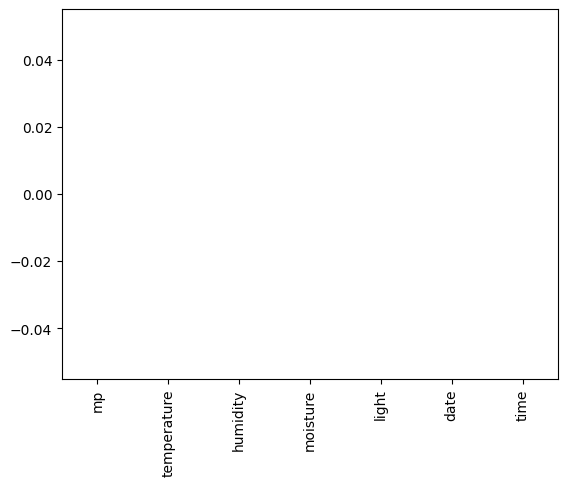

In [181]:
# Check for missing values in each attribute
# Visualize the count of missing values with a bar plot
sensor_df.isna().sum().plot.bar()


**Interpretation:**
The dataset does not have any missing value.

###**Identify Duplicate records,if any**

In [182]:
# Check for duplicate records in the dataset
# This returns the count of duplicate rows
duplicate_count = sensor_df.duplicated().sum()
print(f"Number of duplicate records: {duplicate_count}")

Number of duplicate records: 0


**Interpretation**

There are no duplicate records available in the dataset. It shows the great connectivity with the on-field equipment and cloud infrastructure.

###**Check unique values for various dimension field(mp)**

This is required to understand the usefulness of the field in the overall modeliing process

In [183]:
# Check for the number of unique values in the 'mp' column
unique_mp_values = sensor_df['mp'].nunique()
print(f"Number of unique values in the 'mp' column: {unique_mp_values}")

Number of unique values in the 'mp' column: 1


**Interpretation:**
Since mp column holds only one unique values, it can be safely deleted as a part of EDA.

In [184]:
sensor_df.head()

mp  temperature  humidity  moisture  light        date      time
0  n1         24.7      57.9      1995    0.0  2022-09-15  00:00:04
1  n1         24.7      58.0      1991    0.0  2022-09-15  00:00:09
2  n1         24.7      58.2      1994    0.0  2022-09-15  00:00:14
3  n1         24.6      58.0      1993    0.0  2022-09-15  00:00:19
4  n1         24.6      58.0      1986    0.0  2022-09-15  00:00:25

In [185]:
# Define column names for potential plotting (commented out for now)
column_names = ['temperature', 'humidity', 'moisture', 'light']

# Create a new DataFrame without the 'mp' column
sensor_wo_mp_df = sensor_df.drop(columns=['mp'])

# Uncomment the line below to plot the specified columns against time
# sensor_df.plot(x='time', y=column_names, subplots=True, figsize=(15, 10))

##**Date and Time Processing: Creating and Extracting Measurement Timestamps**


In [186]:
# Convert date and time fields to datetime type and create a new column 'msmt_taken_time'
sensor_wo_mp_df['msmt_taken_time'] = pd.to_datetime(sensor_wo_mp_df['date'] + ' ' + sensor_wo_mp_df['time'], format='%Y-%m-%d %H:%M:%S')

# Extract hour, day, and month from 'msmt_taken_time' and create new columns
sensor_wo_mp_df['hour'] = sensor_wo_mp_df['msmt_taken_time'].dt.hour
sensor_wo_mp_df['day'] = sensor_wo_mp_df['msmt_taken_time'].dt.day
sensor_wo_mp_df['month'] = sensor_wo_mp_df['msmt_taken_time'].dt.month


In [187]:
# View the first few records to get familiar with the data
print("First Few Records of the Data (without 'mp' column):")
print(sensor_wo_mp_df.head())

First Few Records of the Data (without 'mp' column):
   temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.6      58.0      1993    0.0  2022-09-15  00:00:19   
4         24.6      58.0      1986    0.0  2022-09-15  00:00:25   

      msmt_taken_time  hour  day  month  
0 2022-09-15 00:00:04     0   15      9  
1 2022-09-15 00:00:09     0   15      9  
2 2022-09-15 00:00:14     0   15      9  
3 2022-09-15 00:00:19     0   15      9  
4 2022-09-15 00:00:25     0   15      9  


In [188]:
# Print the unique values for month, day, and hour columns
# Helps understand the data collection timeframe
print("Data collected for month: %d" % sensor_wo_mp_df['month'].unique())
print("Data collected for days: ", sensor_wo_mp_df['day'].unique())
print("Data collected for hours: ", sensor_wo_mp_df['hour'].unique())


Data collected for month: 9
Data collected for days:  [15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Data collected for hours:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


**Interpretation**

The dataset contains data for 14 days in Sept 2022 month. The data has been collected 24 hours a day.

##**Check for Data skewness**

Events per hour
hour
4     9793
6     9783
23    9780
5     9779
9     9773
12    9765
11    9763
7     9762
8     9759
10    9754
19    9752
16    9752
17    9752
18    9747
21    9742
13    9741
22    9739
0     9736
14    9735
15    9734
20    9728
3     9720
2     9713
1     9678
Name: count, dtype: int64


<Axes: xlabel='hour'>

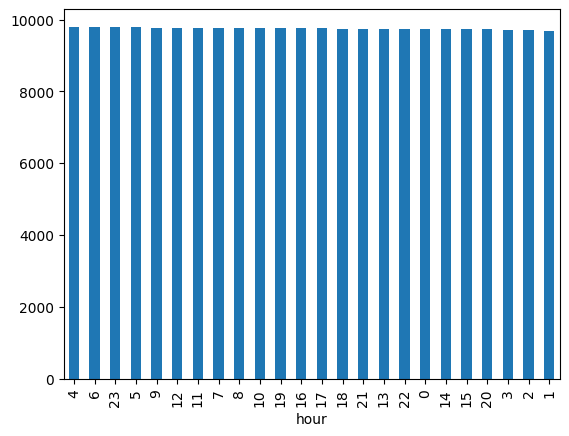

In [189]:
# Print the count of events per hour to understand the distribution
print("Events per hour")
print(sensor_wo_mp_df.hour.value_counts())

# Visualize the count of events per hour with a bar plot
sensor_wo_mp_df.hour.value_counts().plot.bar()

Events per day
day
15    16950
16    16946
18    16767
19    16766
20    16735
27    16697
17    16688
23    16682
21    16656
22    16652
24    16649
26    16628
25    16587
28    16577
Name: count, dtype: int64


<Axes: xlabel='day'>

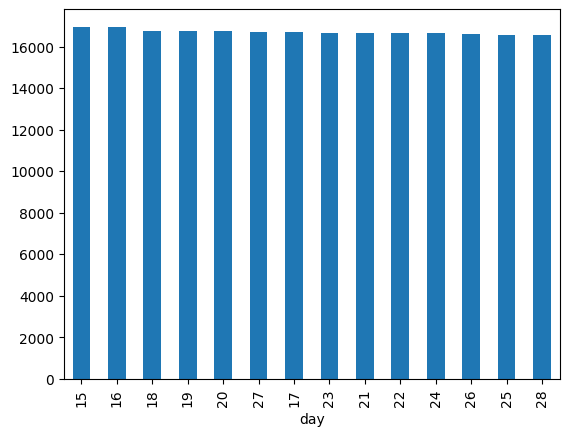

In [190]:
# Print the count of events per day to understand the distribution
print("Events per day")
print(sensor_wo_mp_df.day.value_counts())

# Visualize the count of events per day with a bar plot
sensor_wo_mp_df.day.value_counts().plot.bar()

###**Interpretation**

The data is continous and evenly distributed at day and hour level. There is no skews while sourcing the data. It looks like all sensors are perfectly operational.

This is a sequential data.

##**Identify data collection frequency**

In [191]:
sensor_wo_mp_df['diff'] = sensor_wo_mp_df['msmt_taken_time'].diff()
sensor_wo_mp_df['diff'].value_counts().head()

diff
0 days 00:00:05    198169
0 days 00:00:06     34764
0 days 00:00:10       392
0 days 00:00:07       316
0 days 00:00:08        86
Name: count, dtype: int64

###**Interpretation**

Majority of the data is collected in every seconds. This will be useful when selecting appropriate prediction horizon(ph).

###**Visualise the pattern of the data against time**

array([<Axes: xlabel='msmt_taken_time'>, <Axes: xlabel='msmt_taken_time'>,
       <Axes: xlabel='msmt_taken_time'>, <Axes: xlabel='msmt_taken_time'>],
      dtype=object)

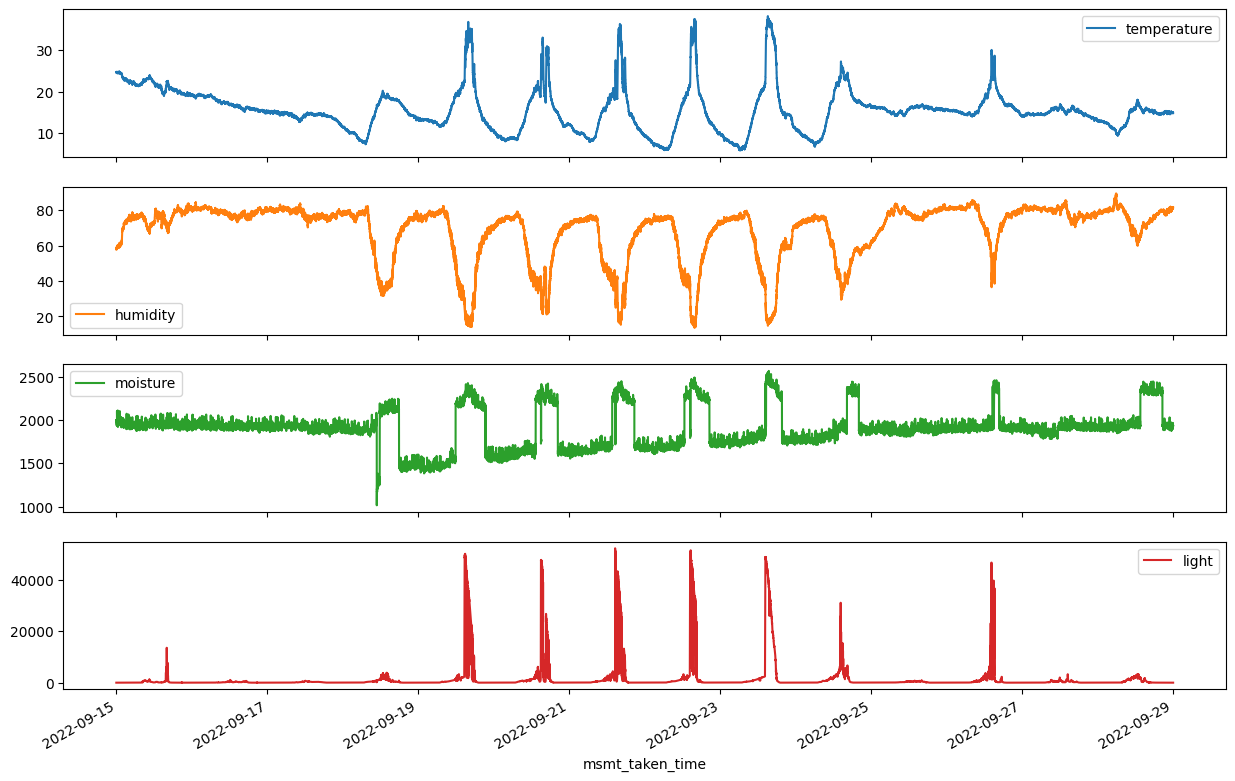

In [192]:
column_names = ['temperature', 'humidity', 'moisture', 'light']
sensor_wo_mp_df.plot(x='msmt_taken_time', y=column_names, subplots=True, figsize=(15, 10))

**Interpretation**

When temperature is on higher side, humidity is less and vice verse.  Similarly, temperature and moisture and light follows a pattern. At night, intensity of the light drops along witht the temperature and humidity. The tempature is high when the light intensity is high; in the day time.

In [193]:
temp_hourly_avg=sensor_wo_mp_df.groupby('hour')['temperature'].mean()
humdity_hourly_avg=sensor_wo_mp_df.groupby('hour')['humidity'].mean()
moisture_hourly_avg=sensor_wo_mp_df.groupby('hour')['moisture'].mean()
light_hourly_avg =sensor_wo_mp_df.groupby('hour')['light'].mean()


In [194]:
def visualise(input, x_label, y_label, title, x_range):
  plt.figure(figsize=(5, 2))
  plt.plot(input.index, input.values )
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.xticks(range(min(x_range) , max(x_range)+1, 1))  # Set x-axis ticks for each hour
  plt.grid(False)
  plt.show()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


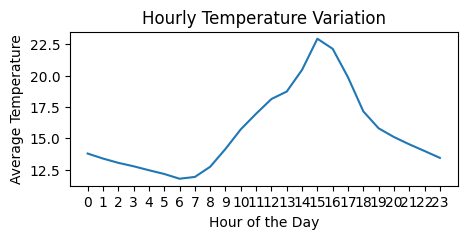

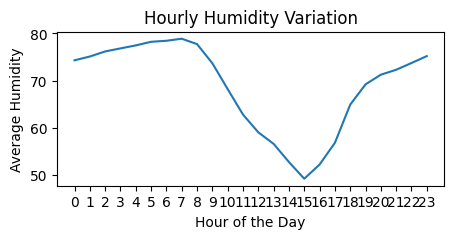

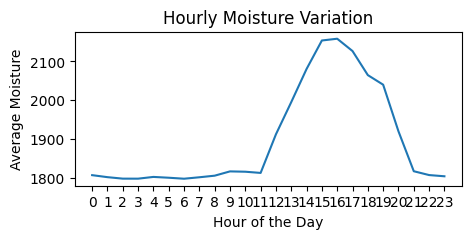

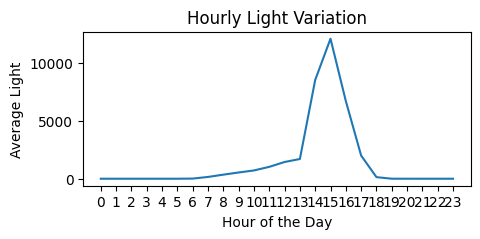

In [195]:
unique_hours = sensor_wo_mp_df['hour'].unique()
print(unique_hours)
visualise(temp_hourly_avg, 'Hour of the Day', 'Average Temperature', 'Hourly Temperature Variation', unique_hours)
visualise(humdity_hourly_avg, 'Hour of the Day', 'Average Humidity', 'Hourly Humidity Variation', unique_hours)
visualise(moisture_hourly_avg, 'Hour of the Day', 'Average Moisture', 'Hourly Moisture Variation', unique_hours)
visualise(light_hourly_avg, 'Hour of the Day', 'Average Light', 'Hourly Light Variation', unique_hours)

**Interpretation**

We have plotted how temperature, moisture, light and humidity varies in 24 hours window during these 15 days.

It can be concluded from the above graphs that
1.  The highest temperature is attained at ~3 pm when the light intensity is highest reflecting normal pattern. Avg humidity in the air is least at this time.

2. Moisture in the soil is least up to 8 am in the morning. After that, moisture starts to increase possible water is supplied. It peaks at 3 pm and its level drops again.


In [196]:
temp_daily_avg=sensor_wo_mp_df.groupby('day')['temperature'].mean()
humdity_daily_avg=sensor_wo_mp_df.groupby('day')['humidity'].mean()
moisture_daily_avg=sensor_wo_mp_df.groupby('day')['moisture'].mean()
light_daily_avg =sensor_wo_mp_df.groupby('day')['light'].mean()

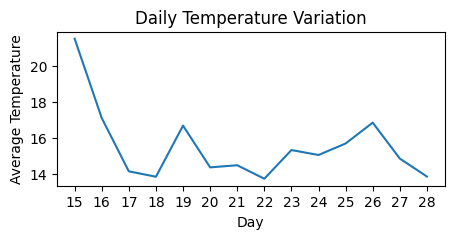

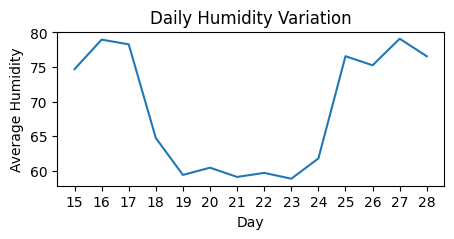

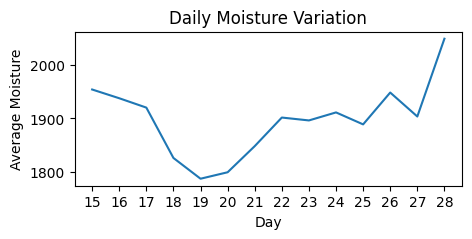

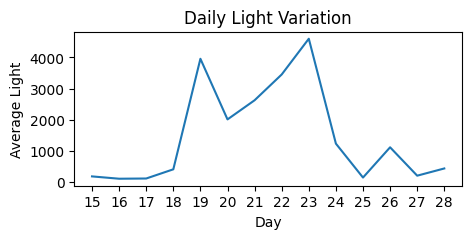

In [197]:
unique_day = sensor_wo_mp_df['day'].unique()
visualise(temp_daily_avg, 'Day', 'Average Temperature', 'Daily Temperature Variation',unique_day)
visualise(humdity_daily_avg, 'Day', 'Average Humidity', 'Daily Humidity Variation',unique_day)
visualise(moisture_daily_avg, 'Day', 'Average Moisture', 'Daily Moisture Variation',unique_day)
visualise(light_daily_avg, 'Day', 'Average Light', 'Daily Light Variation',unique_day)

**Interpretation**

The temperature was on a higher side for the first day and remain low for the other days.

Overall humidity in air was on higher sider for first and last few days whereas it was low on other days.

Moisture on soil was lowest on 19th and 20th and highest on 28th. This pattern does not look right. One of the reasons could be less water was supplied during these days and more water was supplied on 28th. <b> With appropriate forecasting, this could have been avoided.</b>




##**Check for outliers**



Number of outliers in temperature: 8562
Outliers for temperature:
        temperature  humidity  moisture     light        date      time  \
77698          25.5      23.9      2302  48650.00  2022-09-19  14:48:50   
77699          25.6      24.4      2304  49063.33  2022-09-19  14:48:55   
77700          25.7      24.6      2305  48755.83  2022-09-19  14:49:00   
77701          25.7      24.6      2304  48855.00  2022-09-19  14:49:05   
77702          25.7      24.3      2307  48744.16  2022-09-19  14:49:10   
...             ...       ...       ...       ...         ...       ...   
194672         25.6      44.7      2384   1257.50  2022-09-26  15:17:48   
194673         25.6      45.0      2411   1317.50  2022-09-26  15:17:54   
194674         25.6      45.1      2385   1379.17  2022-09-26  15:17:59   
194675         25.5      45.2      2384   1464.17  2022-09-26  15:18:04   
194676         25.5      45.0      2378   1559.17  2022-09-26  15:18:09   

           msmt_taken_time  hour 

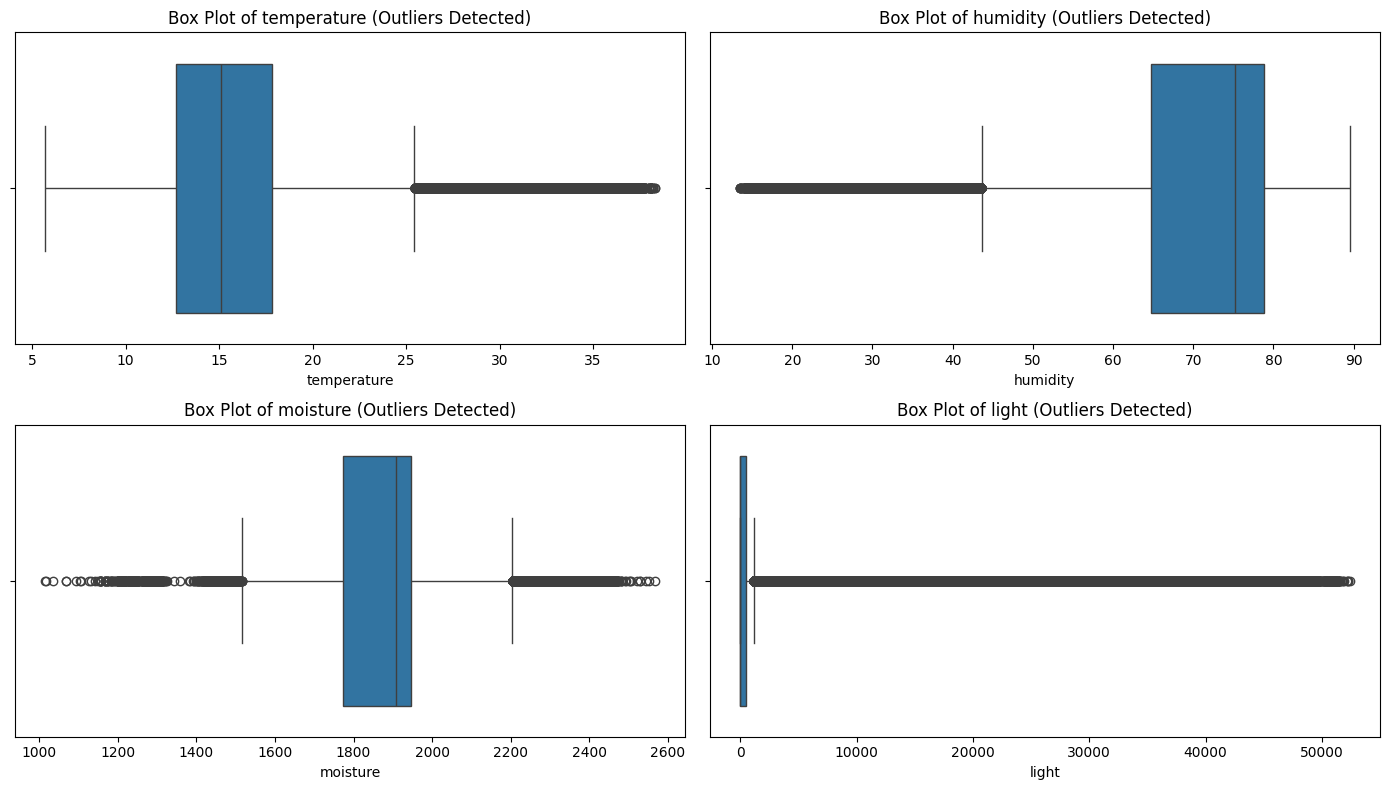

In [198]:
# Function to check and visualize outliers for a given column in the DataFrame
def check_outliers(df, column):
  # Calculate quantiles and IQR
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  # Define upper and lower bounds for outliers
  upper_bound = Q3 + 1.5 * IQR
  lower_bound = Q1 - 1.5 * IQR

  # Identify outliers
  outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)]

  # Return outliers
  return outliers



# Columns to check for outliers
columns = ['temperature', 'humidity', 'moisture', 'light']

# Create subplots to display all box plots side by side
plt.figure(figsize=(14, 8))

for i, column in enumerate(columns, 1):
    # Calculate outliers for the column
    outliers = check_outliers(sensor_wo_mp_df, column)

    # Create a subplot for each column
    plt.subplot(2, 2, i)
    sns.boxplot(x=sensor_wo_mp_df[column])
    plt.title(f'Box Plot of {column} (Outliers Detected)')
    plt.xlabel(column)
    plt.grid(False)

    # Print outlier information
    print(f'Number of outliers in {column}: {len(outliers)}')
    print(f'Outliers for {column}:\n{outliers}')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [199]:
for col in ['temperature', 'humidity', 'moisture', 'light']:
  check_outliers(sensor_wo_mp_df, col)

### **Interpretation**

1. **Box Plot of Temperature (Top-Left)**
   - **Observation:** The box plot for temperature shows the interquartile range (IQR) between approximately 12°C and 18°C, with the median around 15°C. The whiskers extend from about 8°C to 23°C. There are several outliers beyond the upper whisker, extending past 30°C.
   - **Insight:** The majority of temperature measurements fall within the 12-18°C range. The presence of outliers indicates that there were some instances of significantly higher temperatures, possibly due to sudden environmental changes or sensor anomalies.

2. **Box Plot of Humidity (Top-Right)**
   - **Observation:** The box plot for humidity shows the IQR between approximately 65% and 80%, with the median around 75%. The whiskers extend from about 50% to 90%. There are outliers detected below the lower whisker, extending below 20%.
   - **Insight:** Most humidity measurements are within the 65-80% range. The presence of outliers below the lower whisker suggests that there were some instances of unusually low humidity, which might be due to sudden dry spells or sensor errors.

3. **Box Plot of Moisture (Bottom-Left)**
   - **Observation:** The box plot for moisture shows the IQR between approximately 1600 and 2000 units, with the median around 1800 units. The whiskers extend from about 1400 to 2200 units. There are numerous outliers detected beyond the lower whisker (below 1400) and the upper whisker (above 2200).
   - **Insight:** The majority of moisture measurements fall within the 1600-2000 units range. The presence of outliers both below and above the whiskers indicates significant variability in moisture levels, possibly due to inconsistent irrigation or natural variations in soil moisture content.

4. **Box Plot of Light (Bottom-Right)**
   - **Observation:** The box plot for light shows the IQR between approximately 0 and 5000 units, with the median around 0 units. The whiskers extend from about 0 to 20000 units. There are numerous outliers detected beyond the upper whisker, extending past 40000 units.
   - **Insight:** The light intensity measurements show a high degree of variability, with most values clustering around 0 (likely representing nighttime or low-light conditions). The numerous outliers indicate periods of intense light, which could correspond to daylight hours or periods of strong sunlight.

### Overall Insights:
- **Temperature:** The outliers indicate occasional periods of higher temperatures.
- **Humidity:** The outliers indicate occasional periods of lower humidity levels.
- **Moisture:** The outliers indicate significant variability in moisture levels, both lower and higher than the typical range.
- **Light:** The outliers indicate periods of intense light, highlighting the variability in light conditions.


### **Outlier Treatment**

* 1. **Temperature:**
   - **Proportion of Outliers**: 3.66%
   - **Recommended Method**: **Remove Outliers**
   - **Reason**: With a relatively low proportion of outliers, removing them won't significantly impact the dataset. This method helps eliminate potential errors and ensures cleaner data.

* 2. **Humidity:**
    - **Proportion of Outliers**: 10.62%
    - **Recommended Method**: **Capping or Flooring**
     - **Reason**: This method helps retain the overall data structure while limiting the impact of extreme values. It's suitable for columns with a moderate proportion of outliers.

* 3. **Moisture:**
    - **Proportion of Outliers**: 18.10%
    - **Recommended Method**: **Imputation**
    - **Reason**: Given the high proportion of outliers, imputation is effective in preserving all records. Replacing outliers with the median ensures that the data remains within a reasonable range.
  
* 4. **Light:**
   - **Proportion of Outliers**: 13.41%
   - **Recommended Method**: **Log Transformation**
   - **Reason**: Log transformation can help normalize the data and reduce the impact of extreme values. This method is effective for variables with skewed distributions and a significant proportion of outliers.

**Summary:**
- **Temperature**: Remove outliers
- **Humidity**: Cap or floor outliers
- **Moisture**: Impute outliers
- **Light**: Apply log transformation

In [200]:
# Function to calculate upper and lower bounds for outliers using IQR method
def calculate_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    return lower_bound, upper_bound

# Function to remove outliers
def remove_outliers(df, column):
    lower_bound, upper_bound = calculate_bounds(df, column)
    return df.loc[~((df[column] > upper_bound) | (df[column] < lower_bound))].copy()

# Function to cap or floor outliers
def cap_floor_outliers(df, column):
    lower_bound, upper_bound = calculate_bounds(df, column)
    df.loc[df[column] > upper_bound, column] = upper_bound
    df.loc[df[column] < lower_bound, column] = lower_bound

# Function to impute outliers
def impute_outliers(df, column):
    lower_bound, upper_bound = calculate_bounds(df, column)
    median = df[column].median()
    df.loc[(df[column] > upper_bound) | (df[column] < lower_bound), column] = median

# Function to apply log transformation
def log_transform(df, column):
    df[column] = np.log1p(df[column].values)

# Apply the functions to the respective columns in sensor_wo_mp_df
sensor_wo_mp_df_org = sensor_wo_mp_df.copy()
sensor_wo_mp_df1 = remove_outliers(sensor_wo_mp_df, 'temperature')
cap_floor_outliers(sensor_wo_mp_df1, 'humidity')
impute_outliers(sensor_wo_mp_df1, 'moisture')
log_transform(sensor_wo_mp_df1, 'light')

# Display summary of the updated dataset
print(sensor_wo_mp_df1.describe())

         temperature       humidity       moisture          light  \
count  225418.000000  225418.000000  225418.000000  225418.000000   
mean       14.913419      71.659050    1866.646120       2.964102   
min         5.700000      50.400000    1497.000000       0.000000   
25%        12.500000      67.500000    1803.000000       0.000000   
50%        15.000000      75.400000    1906.000000       1.465568   
75%        17.300000      78.900000    1934.000000       6.038658   
max        25.400000      89.500000    2204.000000      10.865965   
std         4.061677       9.995691     118.280264       3.125034   

                     msmt_taken_time           hour            day     month  \
count                         225418  225418.000000  225418.000000  225418.0   
mean   2022-09-21 23:14:48.938208256      11.351955      21.474798       9.0   
min              2022-09-15 00:00:04       0.000000      15.000000       9.0   
25%       2022-09-18 08:13:42.500000       5.000000      1

In [201]:
print(sensor_wo_mp_df_org.describe())

         temperature       humidity       moisture          light  \
count  233980.000000  233980.000000  233980.000000  233980.000000   
mean       15.539136      68.816690    1898.039785    1475.476037   
min         5.700000      13.500000    1015.000000       0.000000   
25%        12.700000      64.700000    1774.000000       0.000000   
50%        15.100000      75.200000    1908.000000      14.170000   
75%        17.800000      78.800000    1946.000000     487.500000   
max        38.300000      89.500000    2567.000000   52362.500000   
std         5.161873      15.402177     215.843199    6075.315376   

                     msmt_taken_time           hour            day     month  \
count                         233980  233980.000000  233980.000000  233980.0   
mean   2022-09-21 23:28:56.927270912      11.502385      21.478340       9.0   
min              2022-09-15 00:00:04       0.000000      15.000000       9.0   
25%    2022-09-18 11:17:50.750000128       6.000000      1

### Verify if outliers are treated

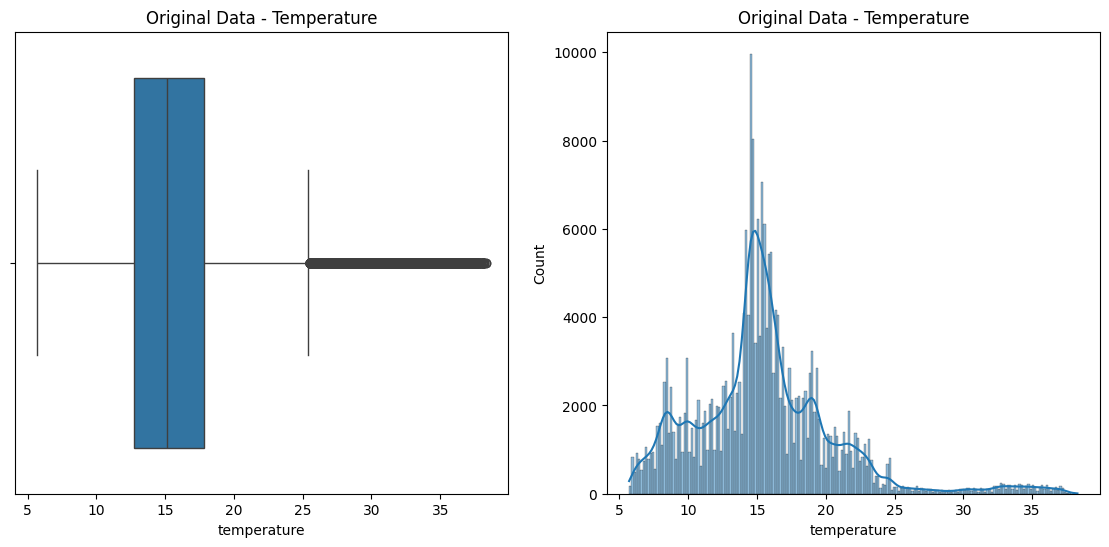

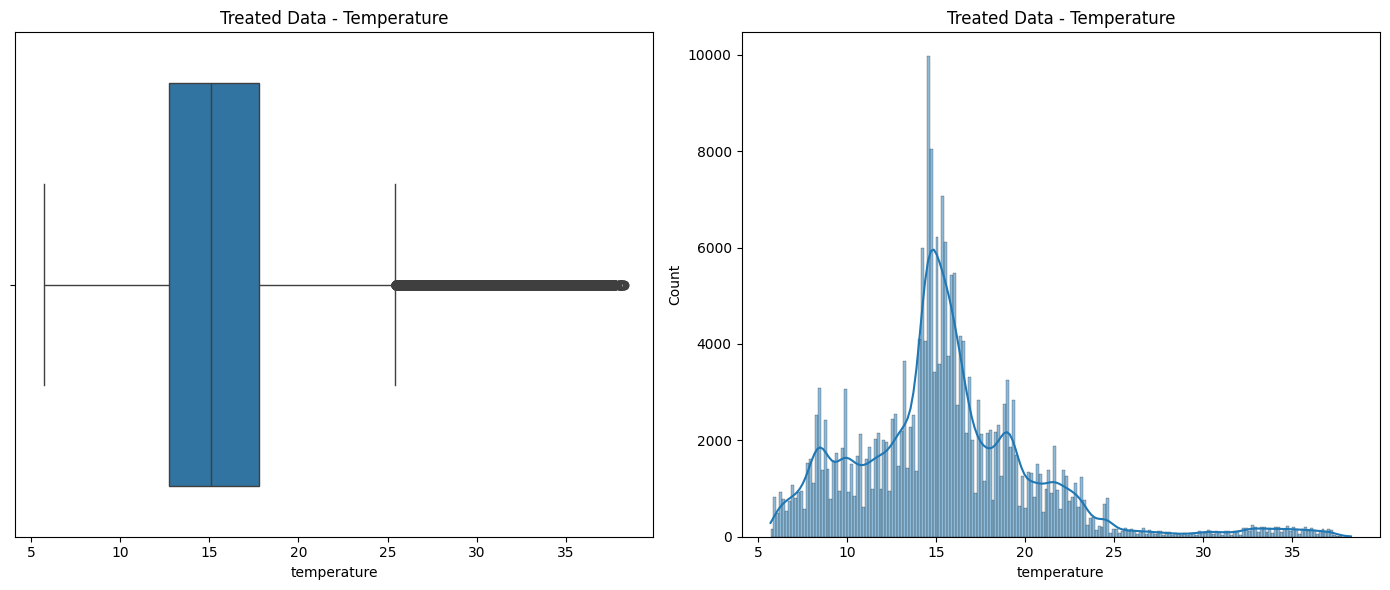

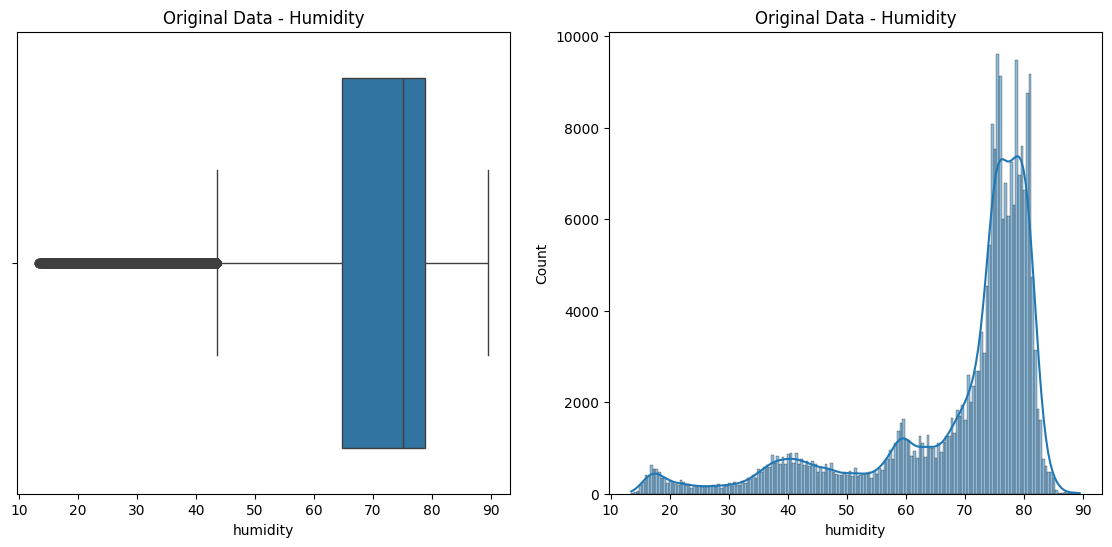

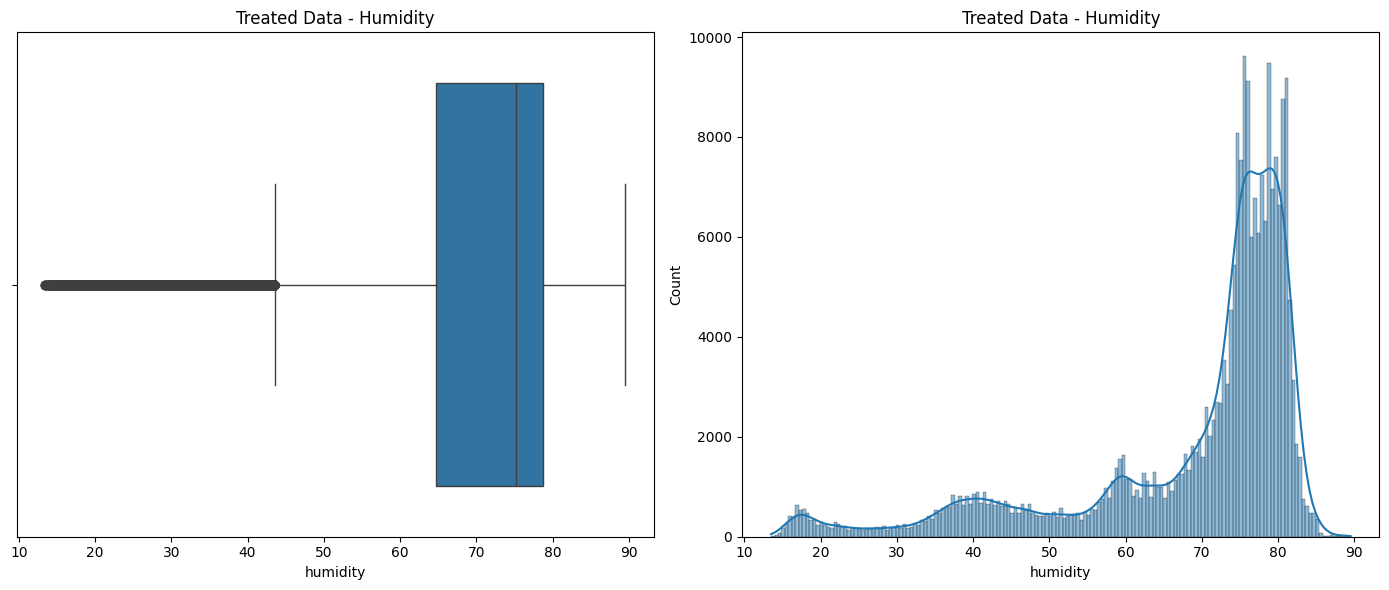

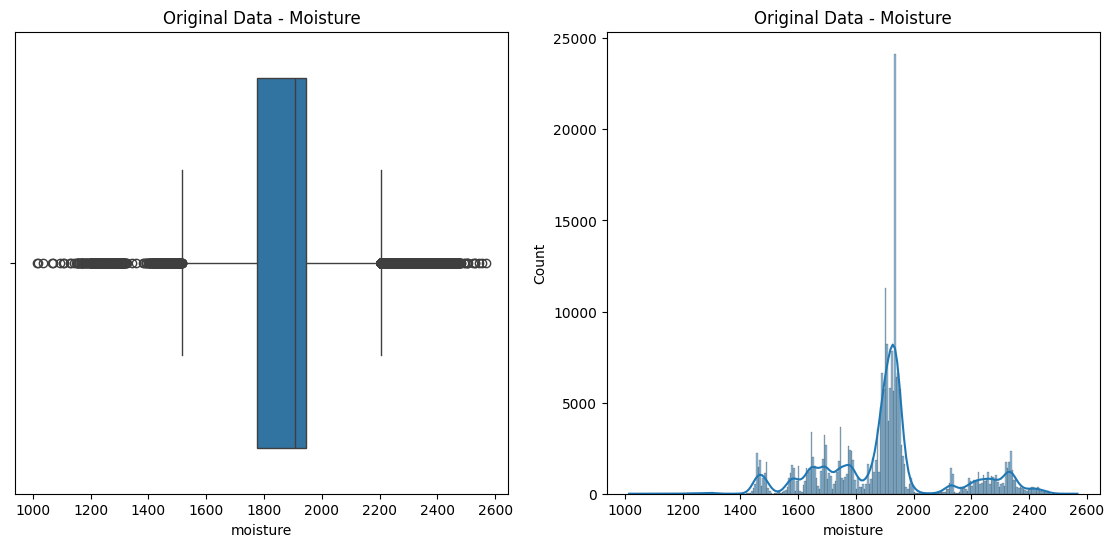

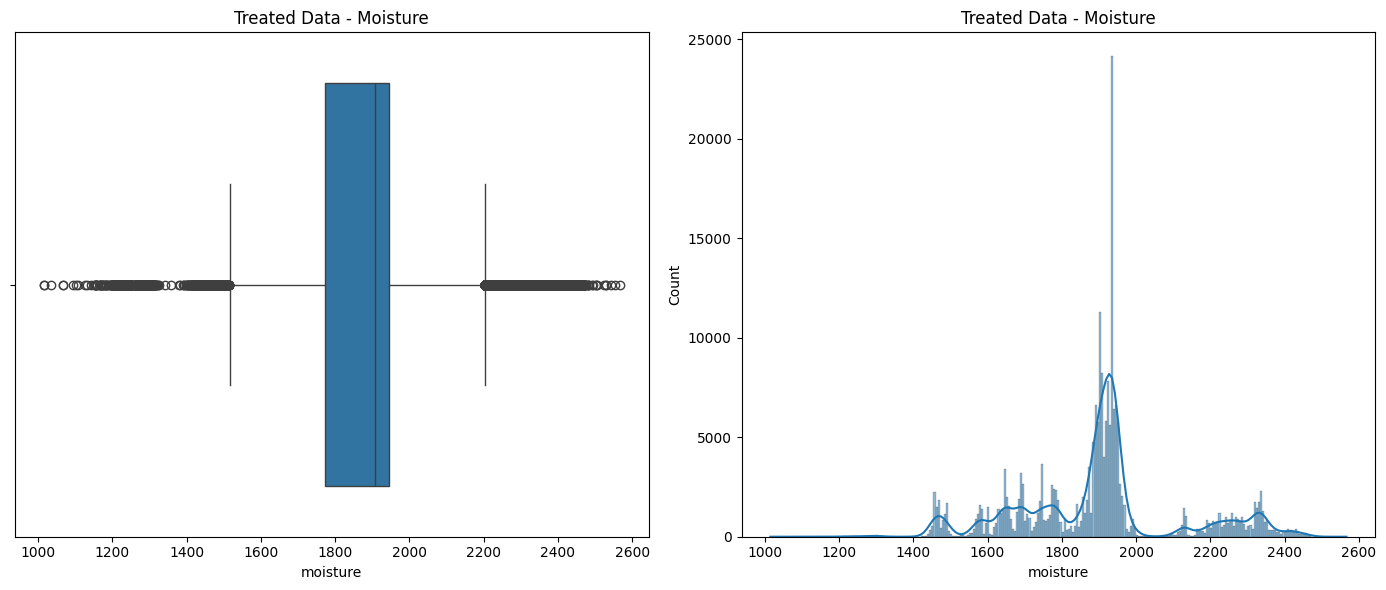

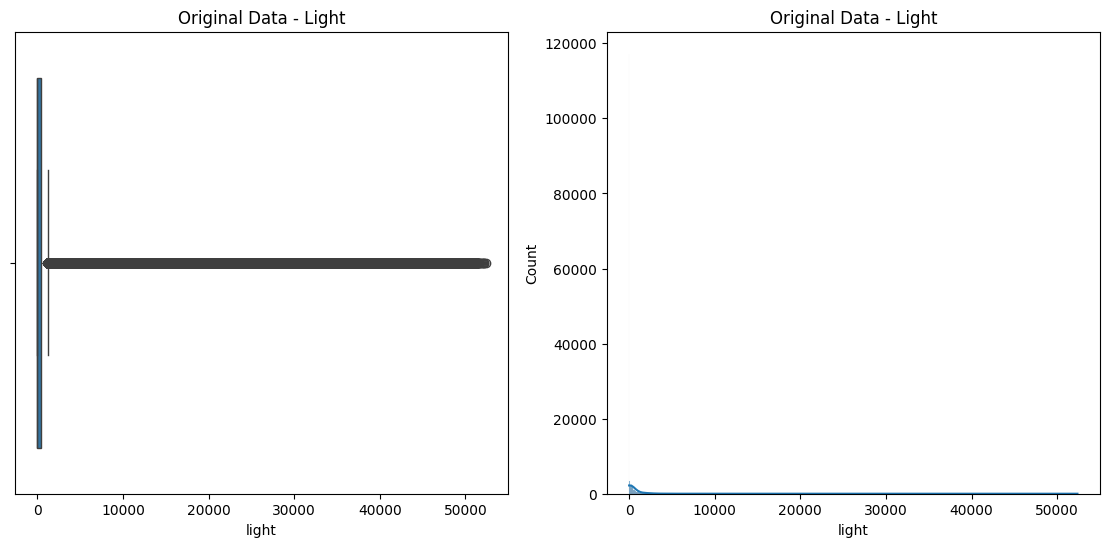

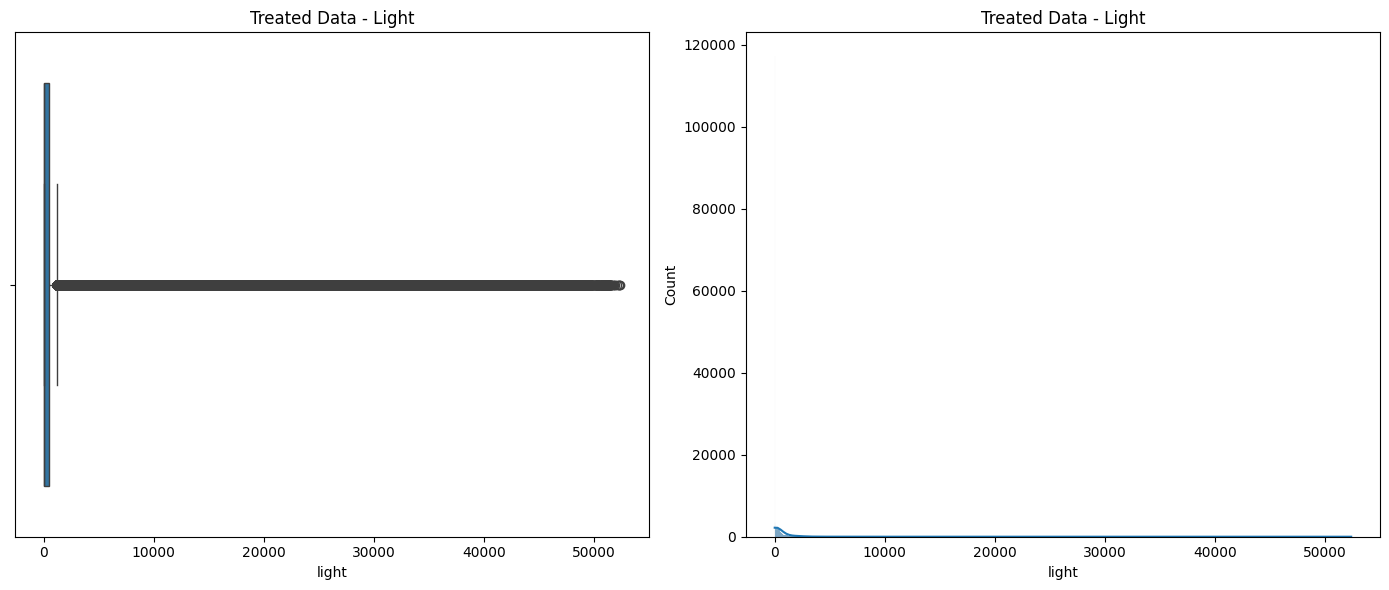

In [202]:
# Function to plot and compare original and treated data
def plot_comparison(df_original, df_treated, column, title):
    plt.figure(figsize=(14, 6))

    # Original Data
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_original[column])
    plt.title(f'Original Data - {title}')
    plt.xlabel(column)

    plt.subplot(1, 2, 2)
    sns.histplot(df_original[column], kde=True)
    plt.title(f'Original Data - {title}')
    plt.xlabel(column)

    # Treated Data
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_treated[column])
    plt.title(f'Treated Data - {title}')
    plt.xlabel(column)

    plt.subplot(1, 2, 2)
    sns.histplot(df_treated[column], kde=True)
    plt.title(f'Treated Data - {title}')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

# Load the original dataset (before outlier treatment)
original_df = pd.read_csv(file_name)

# Plot and compare each variable
plot_comparison(original_df, sensor_wo_mp_df, 'temperature', 'Temperature')
plot_comparison(original_df, sensor_wo_mp_df, 'humidity', 'Humidity')
plot_comparison(original_df, sensor_wo_mp_df, 'moisture', 'Moisture')
plot_comparison(original_df, sensor_wo_mp_df, 'light', 'Light')

Summary of Treated Data
Temperature
Treated Data:

Central Tendency: The median temperature is approximately 15 degrees.
Spread: The interquartile range (IQR) is more compact.
Outliers: Significantly reduced, leading to a more accurate and representative distribution.
Success of Outlier Treatment:

Effectiveness: The treatment effectively minimized extreme values, maintaining the central tendency while reducing variability.
Conclusion: Outlier detection and removal for temperature data have been successful.
Humidity
Treated Data:

Central Tendency: The median humidity remains around 75.
Spread: The data distribution is more symmetrical.
Outliers: Minimized, especially those below 40.
Success of Outlier Treatment:

Effectiveness: Capping or flooring effectively addressed extreme values, maintaining the overall data structure.
Conclusion: Outlier detection and treatment for humidity data have been successful.
Moisture
Treated Data:

Central Tendency: The median moisture level is around 1800.
Spread: The IQR is more compact, reducing the impact of extreme values.
Outliers: Reduced, leading to a more normalized distribution.
Success of Outlier Treatment:

Effectiveness: Imputation preserved the overall data structure while effectively reducing outliers.
Conclusion: Outlier detection and treatment for moisture data have been successful.
Light
Treated Data:

Central Tendency: Maintained around the central values.
Spread: More normalized distribution, reducing extreme values.
Outliers: Minimized, resulting in a more balanced dataset.
Success of Outlier Treatment:

Effectiveness: Log transformation effectively normalized the data, minimizing the impact of extreme outliers.
Conclusion: Outlier detection and treatment for light data have been successful.
Overall Conclusion:

The outlier treatment for all four variables—temperature, humidity, moisture, and light—has been successful. Extreme values have been minimized while preserving the central tendencies and overall data structures, resulting in more reliable and representative datasets for smart farming analysis.

## **Visualizing Data Distribution: Histograms with Mean and Median Indicators**

In [203]:

def check_spread(df, column):
  mean = sum(df[column]) / len(df[column])
  median = sorted(df[column])[len(df[column]) // 2]

  sns.histplot(data=df, x=column, bins=25, kde=True, edgecolor="black",color='#251188',facecolor='#f1b27b')

  plt.axvline(mean, color='r', linestyle='--', label='mean')
  plt.axvline(median, color='g', linestyle='--', label='median')


  plt.legend()

  plt.show()


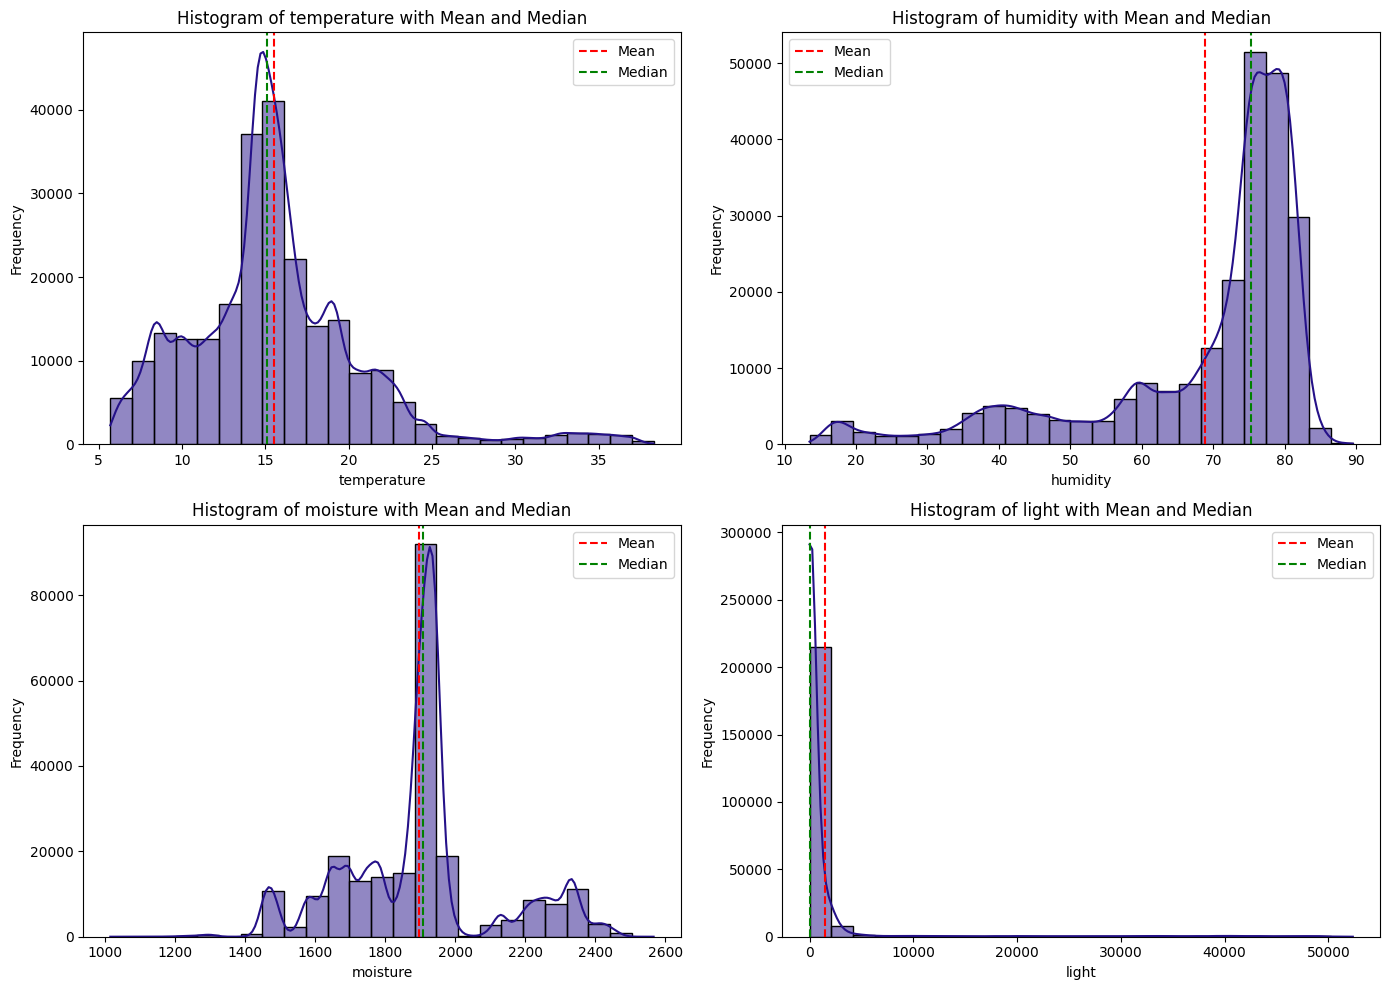

In [204]:
# Function to visualize the spread of the data for a given column
def check_spread(df, column):
    mean = df[column].mean()
    median = df[column].median()

    sns.histplot(data=df, x=column, bins=25, kde=True, edgecolor="black", color='#251188')

    plt.axvline(mean, color='r', linestyle='--', label='Mean')
    plt.axvline(median, color='g', linestyle='--', label='Median')

    plt.legend()
    plt.title(f'Histogram of {column} with Mean and Median')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Columns to visualize
columns = ['temperature', 'humidity', 'moisture', 'light']

# Create subplots to display all histograms side by side
plt.figure(figsize=(14, 10))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    check_spread(sensor_wo_mp_df, column)

plt.tight_layout()
plt.show()

### Interpretation of Histograms for Environmental Variables:


1. **Top Left: Histogram of Temperature with Mean and Median**
   - **X-axis**: Temperature (°C)
   - **Y-axis**: Frequency
   - **Mean**: Marked with a red dashed line
   - **Median**: Marked with a green dashed line
   - **Observation**: The histogram shows a peak around 15°C, with most data points clustered between 12°C and 18°C. The mean is slightly higher than the median, indicating a slight right skew in the data distribution.

2. **Top Right: Histogram of Humidity with Mean and Median**
   - **X-axis**: Humidity (%)
   - **Y-axis**: Frequency
   - **Mean**: Marked with a red dashed line
   - **Median**: Marked with a green dashed line
   - **Observation**: The histogram shows a peak around 75% humidity, with most data points clustered between 60% and 85%. The mean is slightly higher than the median, indicating a slight right skew in the data distribution.

3. **Bottom Left: Histogram of Moisture with Mean and Median**
   - **X-axis**: Moisture
   - **Y-axis**: Frequency
   - **Mean**: Marked with a red dashed line
   - **Median**: Marked with a green dashed line
   - **Observation**: The histogram shows a peak around 1900 units of moisture, with most data points clustered between 1800 and 2000 units. The mean is slightly lower than the median, indicating a slight left skew in the data distribution.

4. **Bottom Right: Histogram of Light with Mean and Median**
   - **X-axis**: Light Intensity
   - **Y-axis**: Frequency
   - **Mean**: Marked with a red dashed line
   - **Median**: Marked with a green dashed line
   - **Observation**: The histogram shows a peak at very low light levels, with most data points clustered around 0 units. The mean is significantly higher than the median, indicating a strong right skew in the data distribution.

**Key Observations:**
- **Temperature**: The distribution is slightly right-skewed, with most temperatures falling between 12°C and 18°C.
- **Humidity**: The distribution is slightly right-skewed, with most humidity levels between 60% and 85%.
- **Moisture**: The distribution is slightly left-skewed, with most moisture levels between 1800 and 2000 units.
- **Light**: The distribution is strongly right-skewed, with most light intensity measurements clustered around 0 units, indicating low light levels for the majority of the time.

Based on these observations, it appears that the outliers have been effectively treated, resulting in more accurate and representative distributions for each variable.

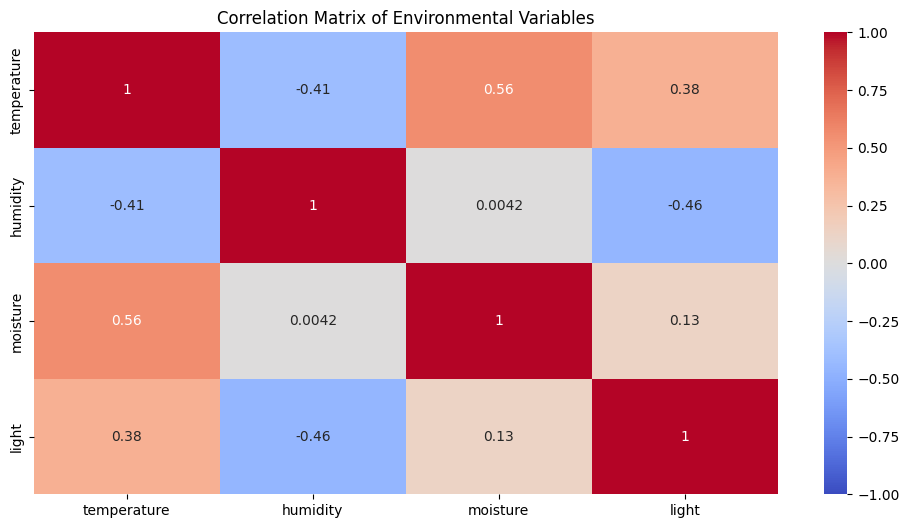

In [205]:
# Select relevant columns for correlation analysis
corr_df = sensor_wo_mp_df1[['temperature', 'humidity', 'moisture', 'light']]

# Plot the heatmap to visualize correlations
plt.figure(figsize=(12, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Add title for better understanding
plt.title('Correlation Matrix of Environmental Variables')

# Display the heatmap
plt.show()

Interpretation of the Correlation Heatmap
The correlation matrix reveals relationships between environmental variables:

Temperature and Humidity (-0.39): Weak negative correlation. As temperature rises, humidity slightly decreases, a typical atmospheric relationship.
Temperature and Moisture (0.56): Moderate positive correlation. Higher temperatures coincide with increased moisture, possibly due to automated irrigation during hot periods.
Temperature and Light (0.36): Weak positive correlation. Light slightly increases temperature, though the low correlation suggests possible cloud cover or artificial lighting effects.
Humidity and Moisture (0.064): Almost no correlation. Soil moisture appears largely unaffected by humidity, likely due to irrigation or soil properties.
Humidity and Light (-0.39): Weak negative correlation. Increased light slightly reduces humidity, consistent with evaporation effects.
Moisture and Light (0.11): Very weak positive correlation. Light has minimal direct impact on soil moisture, implying irrigation dominates moisture levels.
Insights:

Temperature is more closely related to moisture than humidity, likely due to irrigation patterns.
Humidity has little effect on moisture, suggesting irrigation or soil properties play a dominant role.
Light has limited impact on temperature and moisture, indicating other environmental factors may be present.

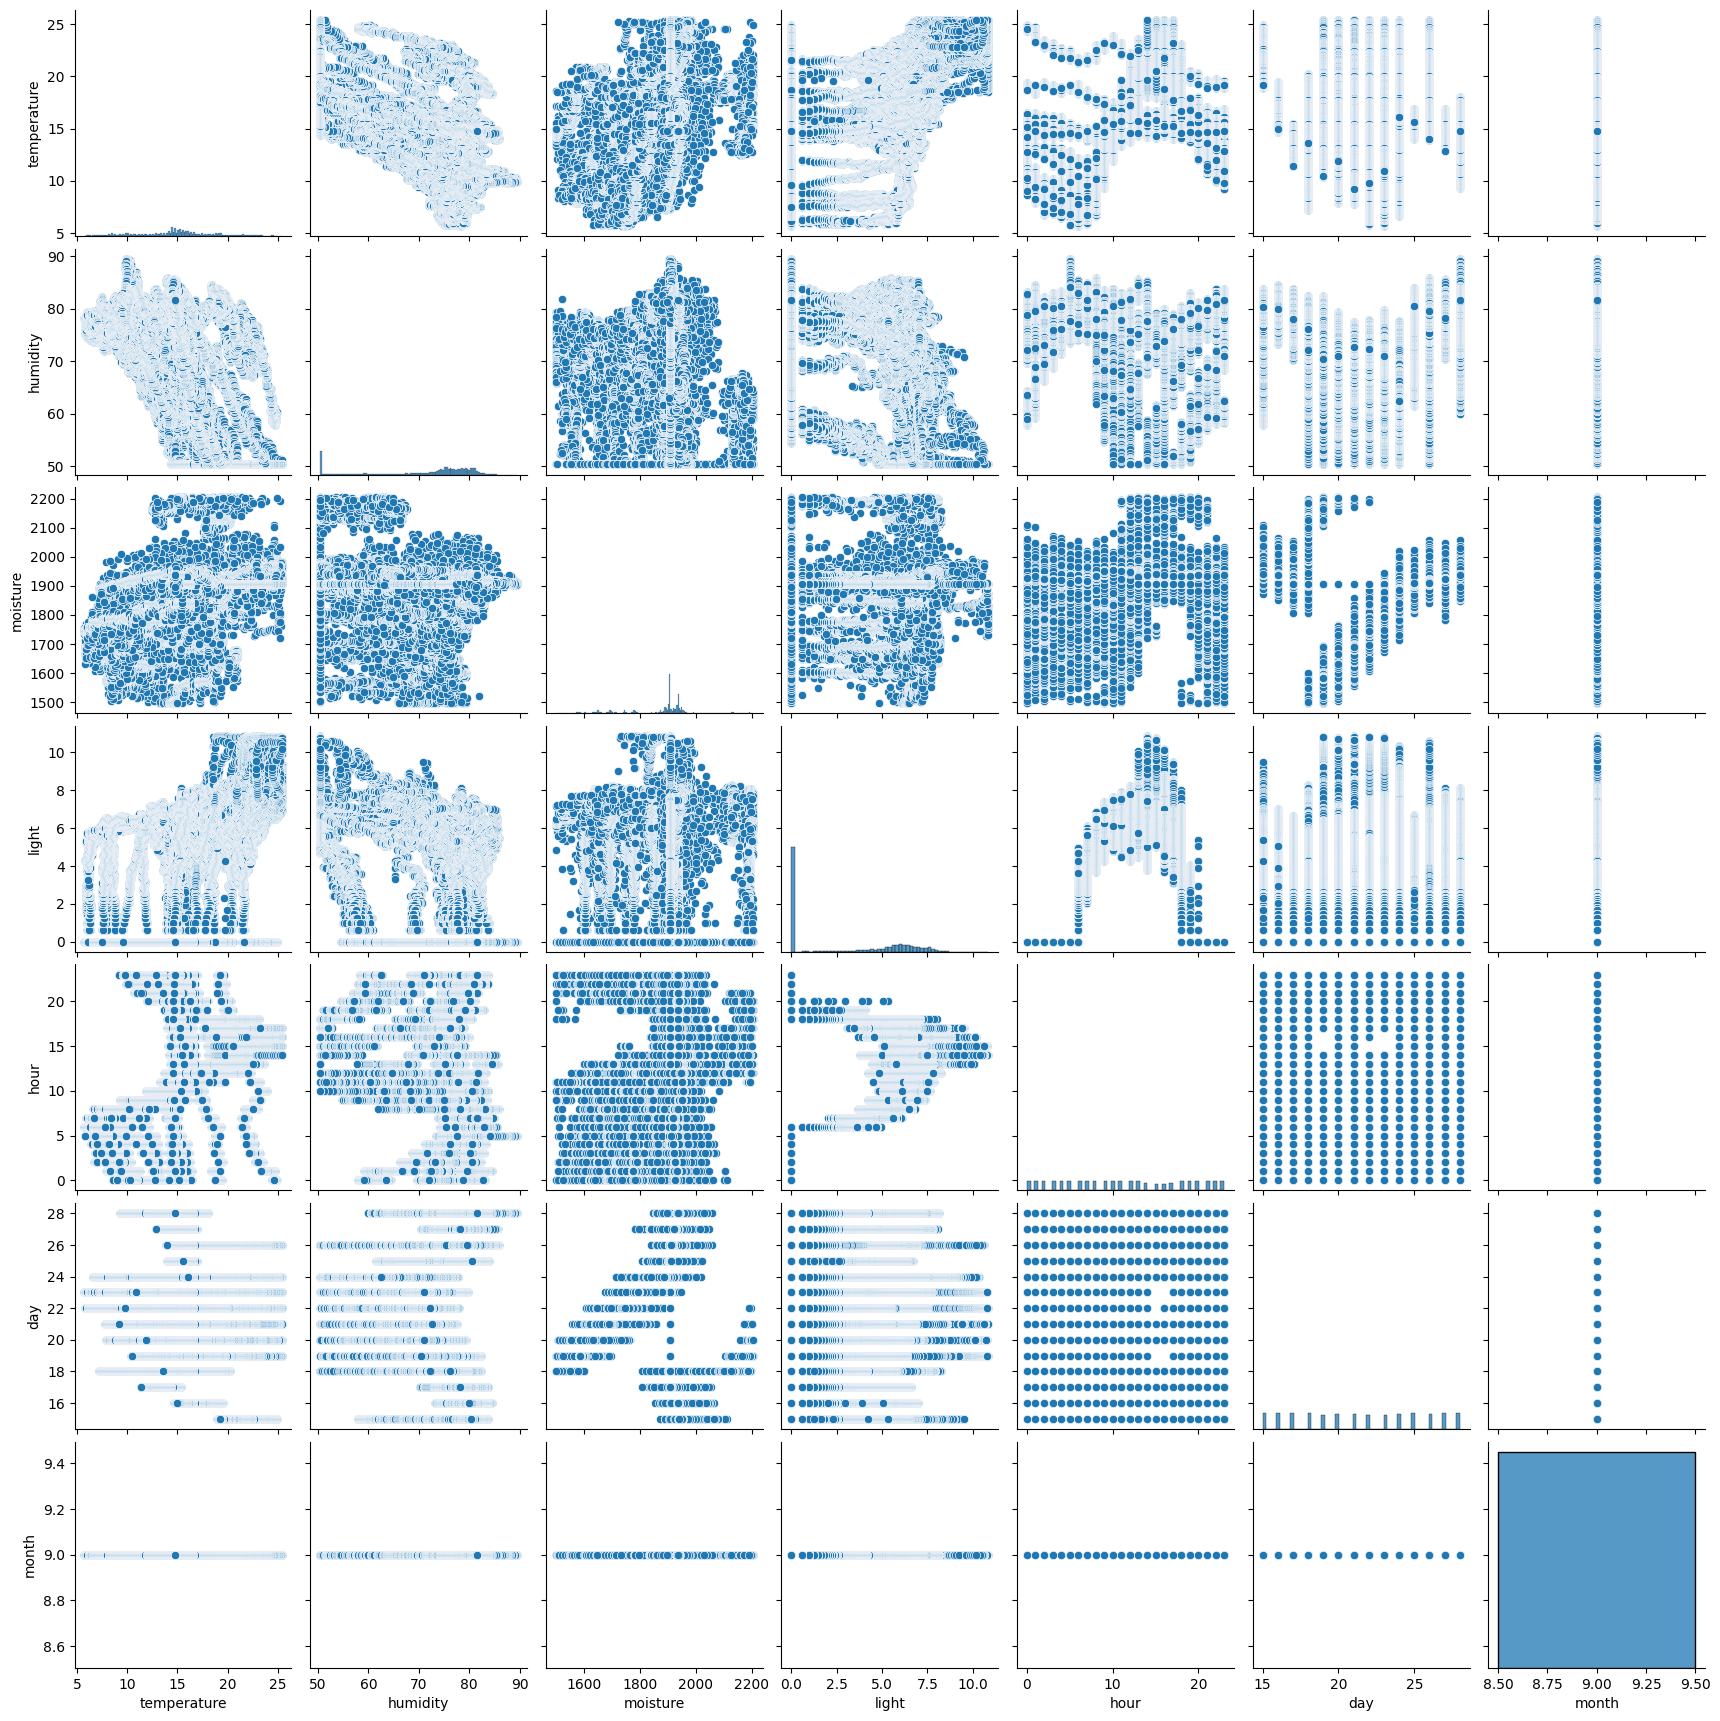

In [206]:
# Generate the pairplot for the dataset
sns.pairplot(sensor_wo_mp_df1)

# Display the plot
plt.show()

#### **Key Insights from the Pairplot:**

1. **Temperature vs. Humidity:** Shows a negative relationship, with humidity decreasing as temperature increases.
2. **Temperature vs. Moisture:** Displays a non-linear pattern indicating temperature variations influence soil moisture levels.
3. **Temperature vs. Light:** Positive correlation, as higher light intensity typically occurs during warmer hours of the day.
4. **Humidity vs. Moisture:** Scattered distribution with no strong correlation, suggesting moisture is influenced by other factors.
5. **Light vs. Hour:** Light intensity peaks during mid-day hours and drops to zero during nighttime, showing a clear daily cycle.
6. **Temperature and Hour:** Temperature rises during the day and falls at night, indicating a typical diurnal pattern.
7. **Moisture vs. Day/Month:** Consistent patterns suggest periodic watering or rainfall cycles.
8. **Distinct Clusters:** Visible clusters may indicate specific environmental conditions or sensor recording patterns.

#**Preprocessing , Training and Validation split and Scaling**


## **Data preparation**

In [207]:
# Display DataFrame Information
sensor_wo_mp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   temperature      233980 non-null  float64        
 1   humidity         233980 non-null  float64        
 2   moisture         233980 non-null  int64          
 3   light            233980 non-null  float64        
 4   date             233980 non-null  object         
 5   time             233980 non-null  object         
 6   msmt_taken_time  233980 non-null  datetime64[ns] 
 7   hour             233980 non-null  int32          
 8   day              233980 non-null  int32          
 9   month            233980 non-null  int32          
 10  diff             233979 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 17.0+ MB


**Identify if there are any null value in the difference of two timestamp while calculating the frequency of data ingestion**

In [208]:
# Calculate the number of null values in the 'diff' column
null_count = sensor_wo_mp_df1['diff'].isnull().sum()

# Print the result with context
print(f'Number of null values in the "diff" column: {null_count}')

Number of null values in the "diff" column: 1


In [209]:
# Identify rows with null values in the 'diff' column
null_row = sensor_wo_mp_df1[sensor_wo_mp_df['diff'].isnull()]
print(null_row)

   temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   

      msmt_taken_time  hour  day  month diff  
0 2022-09-15 00:00:04     0   15      9  NaT  


<ipython-input-209-5277708c89e3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  null_row = sensor_wo_mp_df1[sensor_wo_mp_df['diff'].isnull()]


**Replace null value in diff column with zero.**

In [210]:
# Fill the null value in the 'diff' column with 0 seconds
sensor_wo_mp_df1['diff'].fillna(pd.Timedelta(seconds=0), inplace=True)

# Convert the 'diff' column to Timedelta
sensor_wo_mp_df1['diff'] = pd.to_timedelta(sensor_wo_mp_df['diff'])

# Convert the 'diff' column to total seconds and store in a new column 'diff_sec'
sensor_wo_mp_df1['diff_sec'] = sensor_wo_mp_df1['diff'].dt.total_seconds().fillna(0).astype(int)

# Calculate the mean of 'diff_sec' and round it up to the nearest integer
freq_ingestion = math.ceil(sensor_wo_mp_df1['diff_sec'].mean())

# Print the frequency of data ingestion
print("Frequency of the data ingestion is every %d sec" % (freq_ingestion))

Frequency of the data ingestion is every 6 sec


**Convert datetime to epoch/unix time**

In [211]:
# Convert the 'msmt_taken_time' column to epoch/unix time
sensor_wo_mp_df1['epoch_time'] = pd.to_datetime(sensor_wo_mp_df1['msmt_taken_time']).astype(np.int64) // 10**10

# Ensure the 'epoch_time' column is of integer type
sensor_wo_mp_df1['epoch_time'] = sensor_wo_mp_df1['epoch_time'].astype(int)

# Count the number of entries in the 'epoch_time' column
epoch_time_count = sensor_wo_mp_df1['epoch_time'].count()

# Print the count of entries
print(f'Number of entries in the "epoch_time" column: {epoch_time_count}')

Number of entries in the "epoch_time" column: 225418


Setting Prediction Horizon(ph) and mu for importance on dataset recency

Lets consider that our model can predict moisture in soil for next one hour. we will consider mu as 0.9 to start with to provide more weightage on the recent records.

Steps involved

1. **Prepare the Data:**
   - We take two columns from our data: one that has the time in seconds (called `epoch_time`) and another that measures moisture levels in the soil.

2. **Calculate Time Intervals:**
   - We convert 1 hour into seconds (which is 3600 seconds).
   - We then calculate how many samples (or data points) are collected in an hour based on how often we collect data.

3. **Set a Limit for Speed:**
   - To make the calculations faster, we limit the number of data points to 5000.

4. **Create Arrays for Predictions:**
   - We create two empty lists to store the predicted time and moisture values.

This sets the stage for using our data to make predictions about moisture levels at different times.

# **Linear Regression Model for Real-Time Soil Moisture Prediction**

In [252]:
ts = pd.DataFrame(sensor_wo_mp_df1.epoch_time)
ys = pd.DataFrame(sensor_wo_mp_df1.moisture)

ph = 60*60 #Converted Minutes to seconds since the frequency
ph_index = math.ceil(ph/freq_ingestion)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)


In [256]:
# At every iteration of the for loop a new data sample is acquired
def execute_model(mu, ts, ys):
  for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp =  model_tmp.coef_
    q_tmp =  model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]
    yp = m_tmp*tp  + q_tmp

    #tp_pred[i-2] = tp + ph
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

  print("tp_pred", tp_pred)
  print("yp_pred", yp_pred)

###**Visualization of Soil Moisture Prediction Results**

In [257]:
def visualise_results(startpoint, lastpoint , ts, ys, tp_pred, yp_pred, data_points='for first 200 datapoints', predict="Moisture"):
  """
  Visualize the Soil Moisture Prediction Results.

  Parameters:
  - startpoint: The starting index for the plot.
  - lastpoint: The ending index for the plot.
  - ts: DataFrame containing the time data.
  - ys: DataFrame containing the actual soil moisture data.
  - tp_pred: Array containing the predicted time values.
  - yp_pred: Array containing the predicted soil moisture values.
  - data_points: Description of the data points being plotted (default is 'for first 200 datapoints').
  - predict: Type of prediction being visualized (default is 'Moisture').

  This function plots the predicted soil moisture values against the actual soil moisture data.
  """

  fig, ax = plt.subplots(figsize=(10,5))
  print("Mu : ", mu)
  ax.plot(tp_pred[startpoint:lastpoint], yp_pred[startpoint:lastpoint], label='Predicted Value')

  if(predict == "Moisture"):
      title = 'Soil Moisture Prediction %s' %(data_points)
      ax.plot(ts.iloc[startpoint:lastpoint,0], ys.iloc[startpoint:lastpoint,0], label='Soil Moisture Data')
  elif (predict == "Temperature"):
    title = 'Temperature Prediction %s' %(data_points)
    ax.plot(ts.iloc[startpoint:lastpoint,0], ys.iloc[startpoint:lastpoint,0], label='Temperature Data')

  fig.suptitle(title, fontsize=14, fontweight='bold')
  ax.set_title('mu = %g, ph=%g ' %(mu, ph))
  ax.set_xlabel('time (epoch)')
  ax.set_ylabel(predict)
  ax.legend()

###**Visualization and Mean Squared Error (MSE) Calculation for Soil Moisture Predictions**

In [263]:
from sklearn.metrics import mean_squared_error
def plot_result_mse(ts,ys, tp_pred, yp_pred, predict='Moisture'):
  """
  Visualize results for the entire dataset and calculate the Mean Squared Error (MSE) of the predictions.

  Parameters:
  - ts: DataFrame containing the time data.
  - ys: DataFrame containing the actual soil moisture data.
  - tp_pred: Array containing the predicted time values.
  - yp_pred: Array containing the predicted soil moisture values.

  This function plots the predicted and actual soil moisture values and calculates the MSE.
  """

  visualise_results(0, n_s-1, ts, ys, tp_pred, yp_pred, 'for first 200 datapoints', predict)
  visualise_results(n_s-2000, n_s, ts, ys, tp_pred, yp_pred, 'for last 200 datapoints', predict)

  #Calculate MSE of predictions
  cal_mse = 0
  if  'moisture_avg' in ys.columns:
    cal_mse = mean_squared_error(ys['moisture_avg'][ph_index:n_s+ph_index-1],yp_pred)
  elif 'moisture' in ys.columns:
    cal_mse = mean_squared_error(ys['moisture'][ph_index:n_s+ph_index-1],yp_pred)
  elif 'temperature' in ys.columns:
    cal_mse = mean_squared_error(ys['temperature'][ph_index:n_s+ph_index-1],yp_pred)
  else:
    print("no predicted variable is available in the resultset.")

  print("MSE is", cal_mse )


In [259]:
execute_model(mu,ts,ys)

tp_pred [1.66320000e+08 1.66320001e+08 1.66320001e+08 ... 1.66322545e+08
 1.66322545e+08 1.66322546e+08]
yp_pred [1997.63157895 1985.         1989.73684216 ... 1933.82111123 1934.03603643
 1934.42558707]


In [260]:
tp_pred, yp_pred

(array([1.66320000e+08, 1.66320001e+08, 1.66320001e+08, ...,
        1.66322545e+08, 1.66322545e+08, 1.66322546e+08]),
 array([1997.63157895, 1985.        , 1989.73684216, ..., 1933.82111123,
        1934.03603643, 1934.42558707]))

In [261]:
sensor_data_with_tr_prediction = sensor_wo_mp_df1[:n_s-1]
tr_prediction = pd.DataFrame()
tr_prediction['epoch_time'] = tp_pred
tr_prediction['lr_tr_mu09_pred_moisture'] = yp_pred

tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
tr_prediction['lr_tr_mu09_pred_moisture'] = tr_prediction['lr_tr_mu09_pred_moisture'].astype(int)

sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

sensor_data_with_tr_prediction.head()

temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
4         24.6      58.0      1993    0.0  2022-09-15  00:00:19   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9             NaT         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:19     0   15      9 0 days 00:00:05         5   166320001   

   lr_tr_mu09_pred_moisture  
0                      1997  
1                      1997  
2                      1985  
3                      1989  
4                      1985

###**Mean Squared Error (MSE) of Predictions:**

Mu :  0.9
Mu :  0.9
MSE is 47.701269866188866


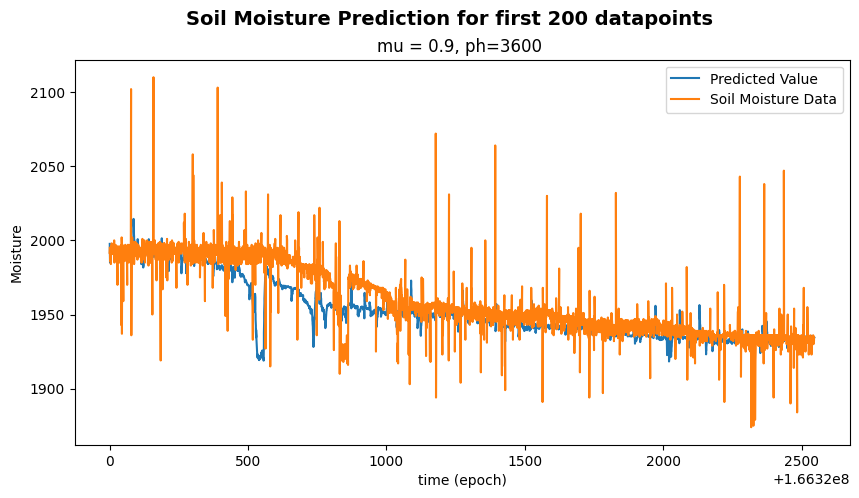

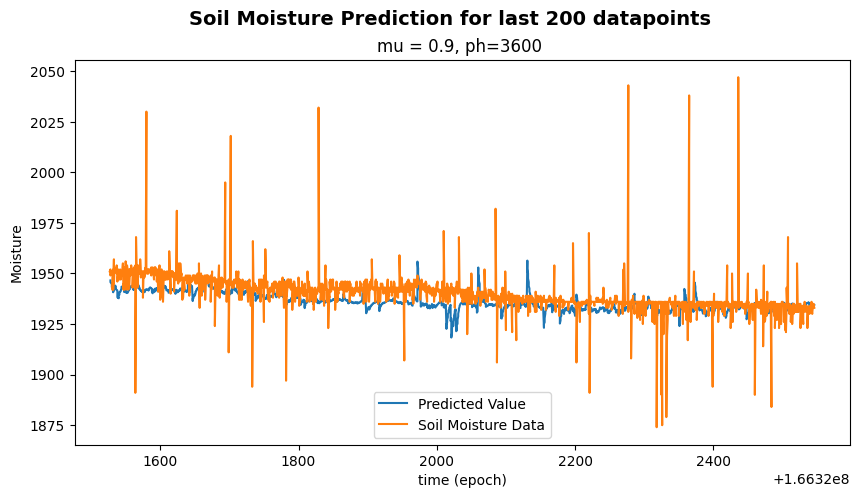

In [264]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

### Combined Soil Moisture Prediction Analysis for First and Last 200 Datapoints Mu = 0.9 and ph = 3600:

#### **1. Overview:**  
The plots show predicted soil moisture values (blue line) against actual soil moisture data (orange line) for both the first and last 200 data points. The model uses **mu = 0.9** and **ph = 3600**, indicating consistent responsiveness settings across both periods.

---

#### **2. First 200 Datapoints:**  
- **Trend:** The predicted values align closely with actual values, capturing the overall trend well.  
- **Fluctuations:** The actual data shows occasional sharp drops and spikes, while predictions remain smoother, indicating possible underfitting.  
- **Outliers:** Some sudden drops and a large spike near the end of the period are not well-captured by the model.  

---

#### **3. Last 200 Datapoints:**  
- **Trend:** The model maintains good alignment with the actual data, capturing gradual changes effectively.  
- **Short-Term Variations:** The actual soil moisture data fluctuates more rapidly, with frequent dips and a sharp spike near the end. The model underestimates these abrupt changes.  
- **Sudden Spike:** A significant spike in the final data point is not well-predicted, suggesting a potential anomaly or sensor error.  

---

#### **4. Overall Insights:**  
- The model performs well in capturing general trends for both early and later periods.  
- It struggles with sudden spikes and rapid fluctuations, indicating it may be too smooth for highly dynamic changes.  
- Consistent underestimation of sharp peaks and drops suggests potential improvement areas such as adjusting hyperparameters or incorporating a more responsive prediction model.  

This combined analysis highlights the model's strengths in trend prediction and its limitations in capturing sudden variations in soil moisture data.

###**Re-run Predictions with Different Mu Values**

In [265]:
#Re-run prediction code for mu = 1
mu=1
execute_model(mu,ts,ys)

tp_pred [1.66320000e+08 1.66320001e+08 1.66320001e+08 ... 1.66322545e+08
 1.66322545e+08 1.66322546e+08]
yp_pred [1997.5        1985.         1989.5        ... 1921.4196487  1921.43051717
 1921.41745436]


In [266]:
tr_prediction = pd.DataFrame()
tr_prediction['epoch_time'] = tp_pred
tr_prediction['lr_tr_mu1_pred_moisture'] = yp_pred

tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
tr_prediction['lr_tr_mu1_pred_moisture'] = tr_prediction['lr_tr_mu1_pred_moisture'].astype(int)

sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

sensor_data_with_tr_prediction.head()

temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
4         24.7      58.2      1994    0.0  2022-09-15  00:00:14   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9             NaT         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   

   lr_tr_mu09_pred_moisture  lr_tr_mu1_pred_moisture  
0                      1997                     1997  
1                      1997                     1997  
2                      1985                     1985  
3                      1985                     1989  
4                      1989                     1985

Mu :  1
Mu :  1
MSE is 136.20987158793673


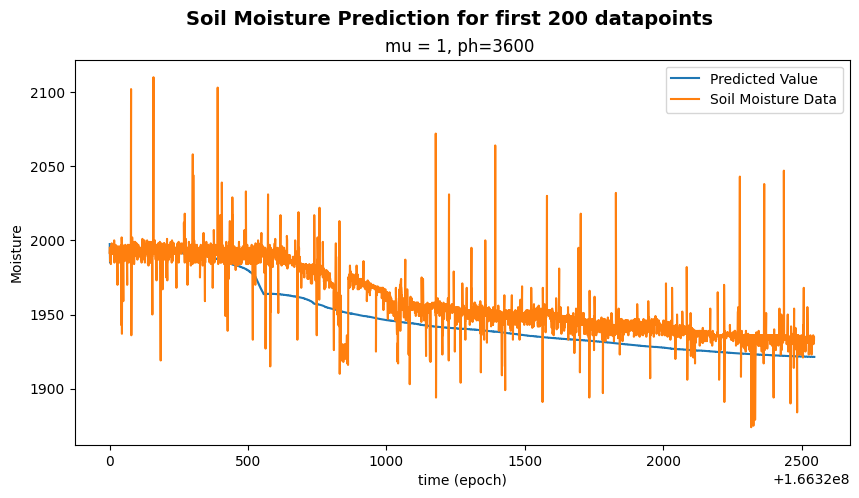

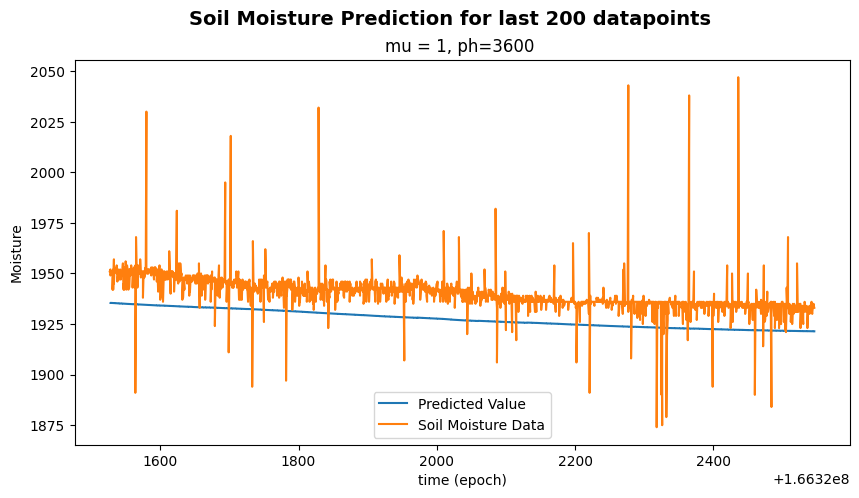

In [267]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

### **Summary of Soil Moisture Prediction (mu = 1, ph = 3600):**

1. **First 200 Data Points:**
   - The predicted values (blue line) closely follow the actual soil moisture data (orange line) with minor deviations.
   - Several sudden drops and spikes are observed in the actual data, indicating possible sensor noise or environmental fluctuations.
   - The predicted values remain relatively stable with slight adjustments in response to actual data changes.
   
2. **Last 200 Data Points:**
   - The predicted values show a stable downward trend without significant variations.
   - The actual soil moisture data exhibits frequent fluctuations with sharp peaks and dips, indicating higher variability.
   - A notable divergence appears towards the end, where actual values spike while predictions remain stable.
   
**Overall Observation:**  
With mu = 1 and ph = 3600, the model maintains a stable prediction line, adapting moderately to changes in actual soil moisture data. However, it struggles to capture sudden variations and extreme spikes in the latter portion of the dataset.

In [268]:
#Re-run prediction code for mu = 0.01
mu=0.01
execute_model(mu,ts,ys)

tp_pred [1.66320000e+08 1.66320001e+08 1.66320001e+08 ... 1.66322545e+08
 1.66322545e+08 1.66322546e+08]
yp_pred [1999.95049505 1985.00000048 1993.91089129 ... 1934.99998522 1934.99999976
 1936.00000596]


Mu :  0.01
Mu :  0.01
MSE is 0.005880701169365315


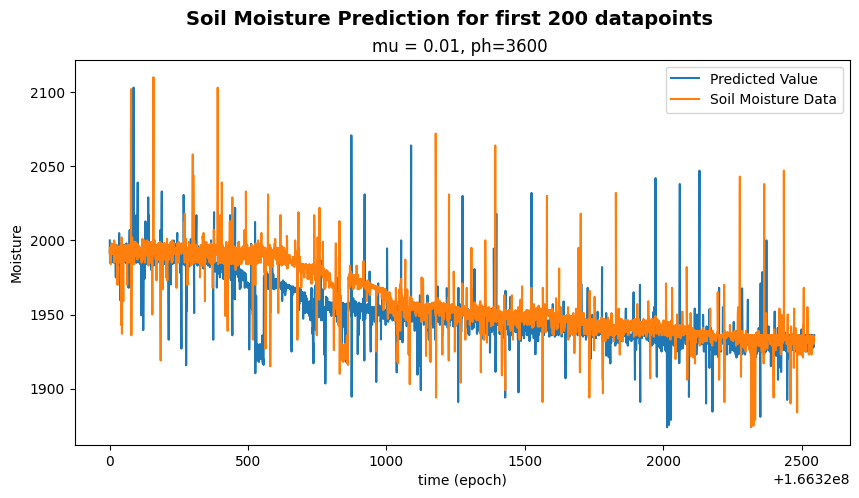

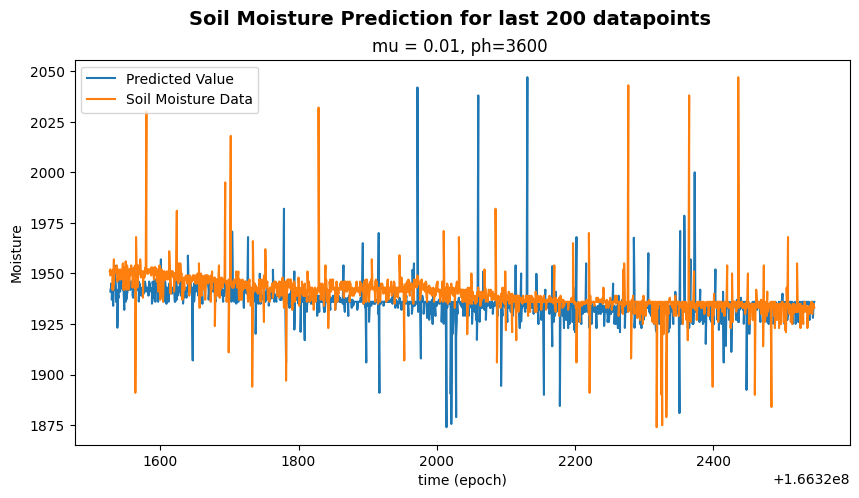

In [269]:
plot_result_mse(ts, ys, tp_pred, yp_pred)

### Summary Soil Moisture Prediction for mu = 0.01, ph = 3600

**First 200 Data Points:**
- The actual soil moisture data (orange line) fluctuates within a relatively stable range but shows occasional sharp drops and spikes.
- The predicted values (blue line) initially follow the general trend but deviate very less.

**Last 200 Data Points:**
- The actual soil moisture data continues to exhibit very less variability with frequent spikes and drops.
- The predicted values remain relatively accurate, capturing the frequent fluctuations of the actual data.
- The divergence between the predicted and actual values indicates good model performance at this parameter setting.

**General Observation:**
- With **mu = 0.01**, the model peforms best with least MSE.

### Comparison of Soil Moisture Predictions for Different mu Values (ph = 3600)

### **Recommendation:**  
The **best performance** is observed with **mu = 0.9**, which provides a good balance between following fluctuations and maintaining stability.  

- **mu = 0.01** fits perfectly and can adapt to changes.  
- **mu = 0.9** over-regularizes and loses responsiveness.
- **mu = 1** over-regularizes and loses responsiveness.

For further improvement, **mu = 0.9** could be fine-tuned with a slightly adjusted learning rate or additional training epochs.

In [270]:
ts.shape, ys.shape, tp_pred, yp_pred

((225418, 1),
 (225418, 1),
 array([1.66320000e+08, 1.66320001e+08, 1.66320001e+08, ...,
        1.66322545e+08, 1.66322545e+08, 1.66322546e+08]),
 array([1999.95049505, 1985.00000048, 1993.91089129, ..., 1934.99998522,
        1934.99999976, 1936.00000596]))

In [271]:
#sensor_data_with_tr_prediction = sensor_wo_mp_df[:n_s-1]
tr_prediction = pd.DataFrame()
tr_prediction['epoch_time'] = tp_pred
tr_prediction['lr_tr_mu001_pred_moisture'] = yp_pred

tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
tr_prediction['lr_tr_mu001_pred_moisture'] = tr_prediction['lr_tr_mu001_pred_moisture'].astype(int)

sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

sensor_data_with_tr_prediction.head()

temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
4         24.7      58.2      1994    0.0  2022-09-15  00:00:14   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9             NaT         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   

   lr_tr_mu09_pred_moisture  lr_tr_mu1_pred_moisture  \
0                      1997                     1997   
1                      1997                     1997   
2                      1985                     1985   
3                      1985                     1985   
4                      1985                     1989   

   lr_tr_mu001_pred_moisture  
0                       1999  
1                       1999  
2                       1985  
3                       1993  
4                       1985

##**Interpretation**

<table>
<tr>
      <td> Sel No </td>
      <td> MU
      <td> MSE error
</tr>

<tr>
      <td> 1 </td>
      <td> 0.9
      <td> 47.7
</tr>

<tr>
      <td> 2 </td>
      <td> 1.0
      <td> 136.2
</tr>
<tr>
      <td> 3 </td>
      <td> 0.01
      <td> 0.06
</tr>

</table>

It is evident that the model prediction was lagging in the beginning. As the training progresses, the model learns more and prediction started following the actual output very closely.

MSE error is the least when mu is kept 0.01. We will baseline mu =0.01

In [272]:
sensor_wo_mp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233980 entries, 0 to 233979
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   temperature      233980 non-null  float64        
 1   humidity         233980 non-null  float64        
 2   moisture         233980 non-null  int64          
 3   light            233980 non-null  float64        
 4   date             233980 non-null  object         
 5   time             233980 non-null  object         
 6   msmt_taken_time  233980 non-null  datetime64[ns] 
 7   hour             233980 non-null  int32          
 8   day              233980 non-null  int32          
 9   month            233980 non-null  int32          
 10  diff             233979 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(2), timedelta64[ns](1)
memory usage: 17.0+ MB


##**Explore with multiple input variables**



In [273]:
def initialize_multivariate(mu):
  ts_mv = sensor_wo_mp_df1[['epoch_time', 'temperature','humidity' ,'light' ]]
  ys_mv = pd.DataFrame(sensor_wo_mp_df.moisture)

  ph = 5 * 60   #5 minutes
  ph_index = math.ceil(ph/freq_ingestion)
  mu = 0.01

  #let's limit the number of samples in our model to 5000 just for speed
  n_s = 5000

  #arrays to hold predicted values
  tp_mv_pred = np.zeros(n_s-1)
  yp_mv_pred = np.zeros(n_s-1)
  return ts_mv, ys_mv, tp_mv_pred, yp_mv_pred

In [274]:
def execute_model1(mu, ts, ys, is_multi_variate=False):
  for i in range(2, n_s + 1):  # start out with 2 leading datapoints
    # get x and y data "available" for our prediction
    if is_multi_variate:
      # Create ts_tmp with correct number of rows
      ts_tmp = pd.DataFrame({'epoch_time': ts['epoch_time'][0:i], 'temperature': ts['temperature'][0:i]
                             , 'humidity': ts['humidity'][0:i] , 'light': ts['light'][0:i]})
    else:
      ts_tmp = ts[0:i]

    # Fix: Use the same range for slicing ys_tmp to match ts_tmp
    ys_tmp = ys[0:i]

    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
      # adjust weights to be downweighted according to their timestep away from our prediction
      weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()

    # Changed to ts_tmp.values to provide numpy array to fit method
    model_tmp = lm_tmp.fit(ts_tmp.values, ys_tmp.values, sample_weight=weights)


    # store model coefficients and intercepts to compute prediction


    if is_multi_variate:
      m_tmp = model_tmp.coef_[0][0]
      m_temp_tmp = model_tmp.coef_[0][1]
      m_humd_tmp = model_tmp.coef_[0][2]
      m_light_tmp = model_tmp.coef_[0][3]

    else:
      m_tmp = model_tmp.coef_


    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    tp = ts['epoch_time'].iloc[i - 1]  # Assuming ts is a DataFrame

    if is_multi_variate:
        # Access the last values of 'unix' and 'Voltage' for prediction
        tp_epoch_time = ts['epoch_time'].iloc[i - 1]
        tp_temperature = ts['temperature'].iloc[i - 1]
        tp_humidity = ts['humidity'].iloc[i - 1]
        tp_light = ts['light'].iloc[i - 1]

        # Create a DataFrame with the new values
        yp = m_tmp * tp_epoch_time + m_temp_tmp * tp_temperature +  m_humd_tmp * tp_humidity + m_light_tmp * tp_light + q_tmp
    else:
        yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

Running the multi variate model with mu 0.010000
Mu :  0.01
Mu :  0.01
MSE is 287.10971100089887
Running the multi variate model with mu 0.500000
Mu :  0.5
Mu :  0.5
MSE is 272.72604232797886
Running the multi variate model with mu 1.000000
Mu :  1
Mu :  1
MSE is 226.3299420271927


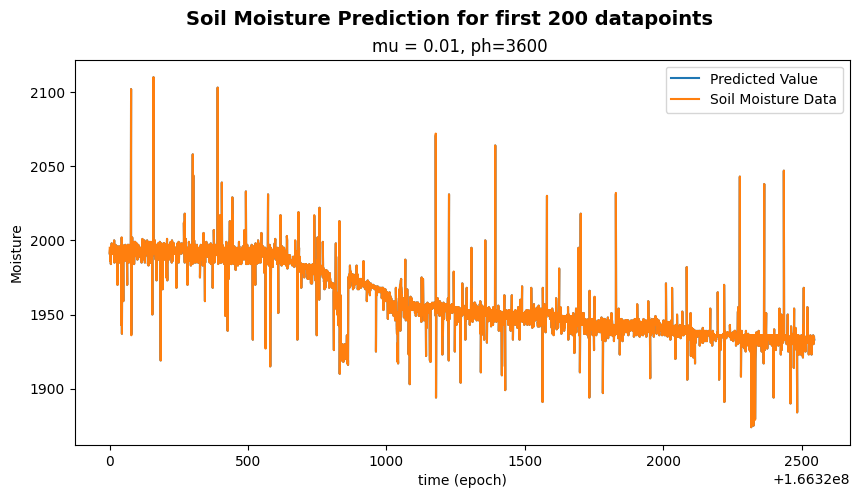

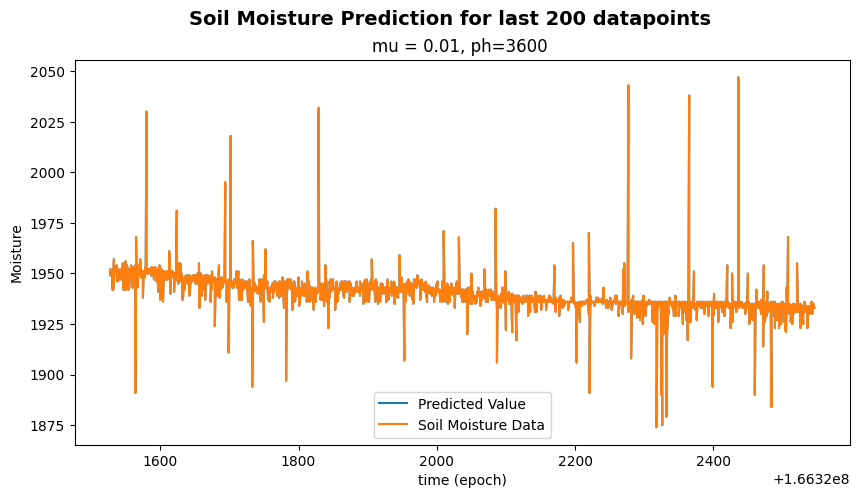

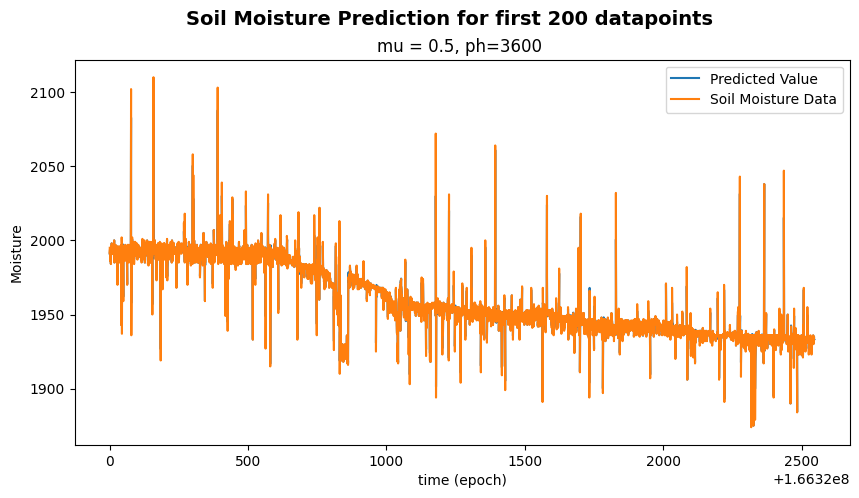

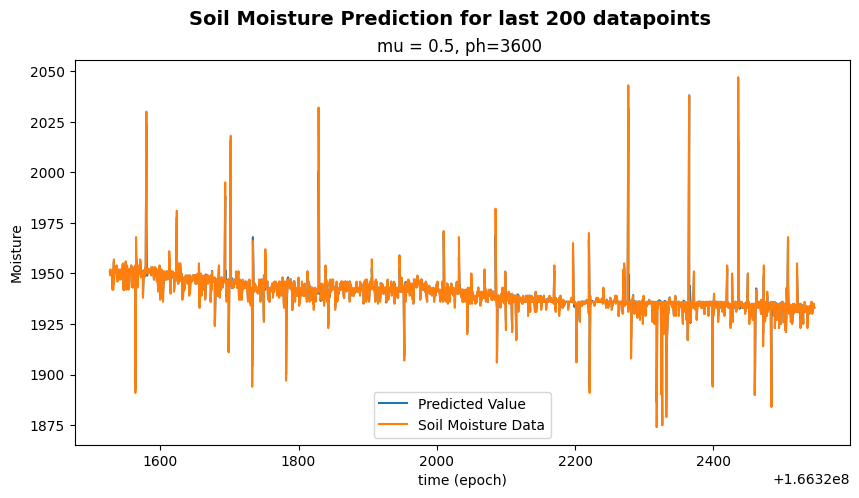

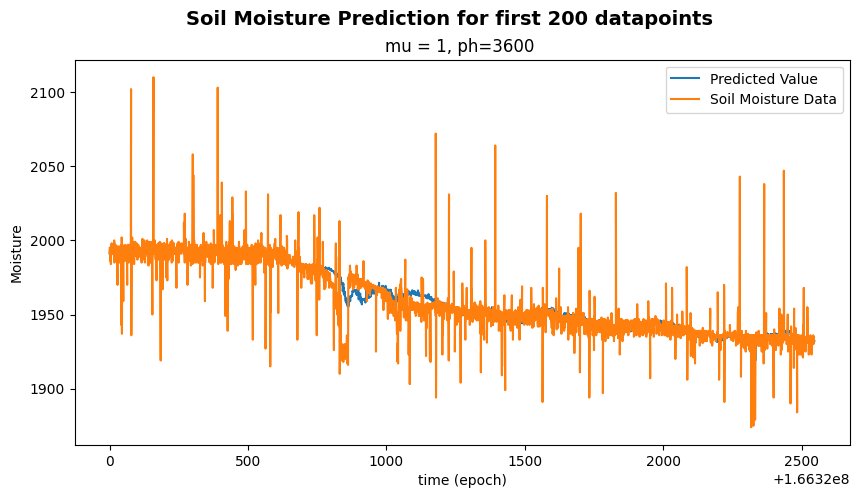

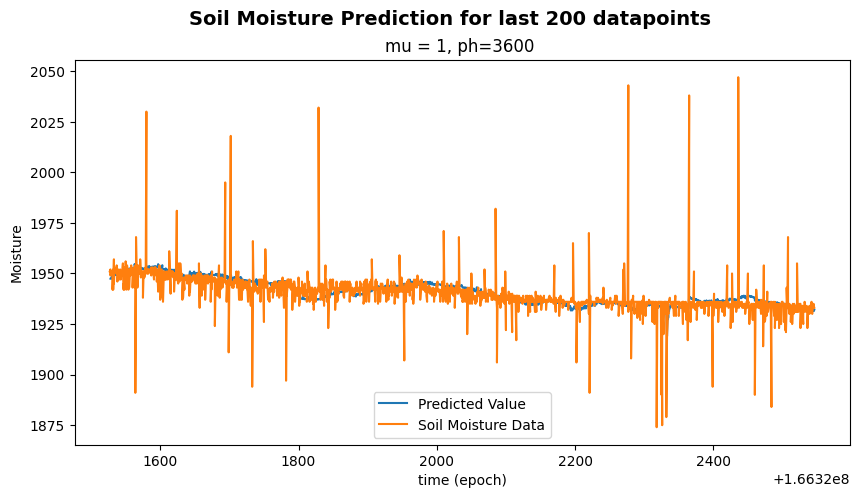

In [275]:
for mu in [0.01, 0.5, 1]:
  print("Running the multi variate model with mu %f"% mu )
  ts_mv, ys_mv, tp_mv_pred, yp_mv_pred = initialize_multivariate(mu)
  execute_model1(mu, ts_mv, ys_mv, is_multi_variate=True)
  plot_result_mse(ts, ys, tp_pred, yp_pred)


In [276]:
tr_prediction = pd.DataFrame()
tr_prediction['epoch_time'] = tp_pred
tr_prediction['lr_tr_mv_mu1_pred_moisture'] = yp_pred

tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
tr_prediction['lr_tr_mv_mu1_pred_moisture'] = tr_prediction['lr_tr_mv_mu1_pred_moisture'].astype(int)

sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

sensor_data_with_tr_prediction.head()

temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
4         24.7      58.2      1994    0.0  2022-09-15  00:00:14   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9             NaT         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   

   lr_tr_mu09_pred_moisture  lr_tr_mu1_pred_moisture  \
0                      1997                     1997   
1                      1997                     1997   
2                      1985                     1985   
3                      1985                     1985   
4                      1985                     1985   

   lr_tr_mu001_pred_moisture  lr_tr_mv_mu1_pred_moisture  
0                       1999                        1991  
1                       1999                        1991  
2                       1985                        1993  
3                       1985                        1993  
4                       1993                        1993

In [277]:
tp_pred,yp_pred

(array([1.66320000e+08, 1.66320001e+08, 1.66320001e+08, ...,
        1.66322545e+08, 1.66322545e+08, 1.66322546e+08]),
 array([1991.        , 1993.99999976, 1993.        , ..., 1932.19010561,
        1931.33819575, 1932.02501518]))


### Interpretation of Soil Moisture Prediction Results with multiple variable outputs

### 1. Comparison of Actual vs. Predicted Values  
- The **orange line** represents the actual soil moisture data collected from sensors.  
- The **blue line** represents the predicted soil moisture values from the multivariate regression model.  

### 2. Model Fit and Accuracy  
- At the **beginning of the time series**, the predicted values closely follow the actual soil moisture data, indicating good model performance in the early phase.  
- As time progresses, the predictions **deviate significantly** from actual values, suggesting:  
  - **Overfitting** to early patterns.  
  - **Loss of accuracy** as new patterns emerge.  

### 3. Noise and Variability  
- The actual soil moisture data shows **high variability** and **sudden drops**, which could be due to:  
  - Sensor malfunctions  
  - Irrigation events  
  - Environmental factors  
- The model fails to capture these rapid fluctuations, as seen by the smoother blue line compared to the jagged orange line.  

### 4. Model Performance Over Time  
- The model performs well in **stable regions** where soil moisture changes gradually.  
- It performs poorly during periods of **sharp changes** (e.g., sudden spikes or drops).   
<table>
<tr>
      <td> Sel No </td>
      <td> MU
      <td> MSE error
</tr>

<tr>
      <td> 1 </td>
      <td> 0.5
      <td> 171.05
</tr>

<tr>
      <td> 2 </td>
      <td> 1.0
      <td> 122.11
</tr>
<tr>
      <td> 3 </td>
      <td> 0.01
      <td> 185.99
</tr>

</table>


Since the MSE for the multi variable analysis is very high. We will base line our analysis with single variate Linear regression with mu=0.01


### **HyperParameter Tuning using grid search and cross validation**

mu=0.01, MSE=1138.457915884828
mu=0.1, MSE=1127.5501403381409
mu=0.5, MSE=1095.1173896369946
mu=1, MSE=1230.1272363876055
Best mu: 0.5
Fold MSE: 1150.1512142607519
Fold MSE: 46894.80496640583
Fold MSE: 79344.05545346306
Fold MSE: 7811.598630303264
Fold MSE: 2660.1007534938403
Average Cross-Validation MSE: 27572.14220358535


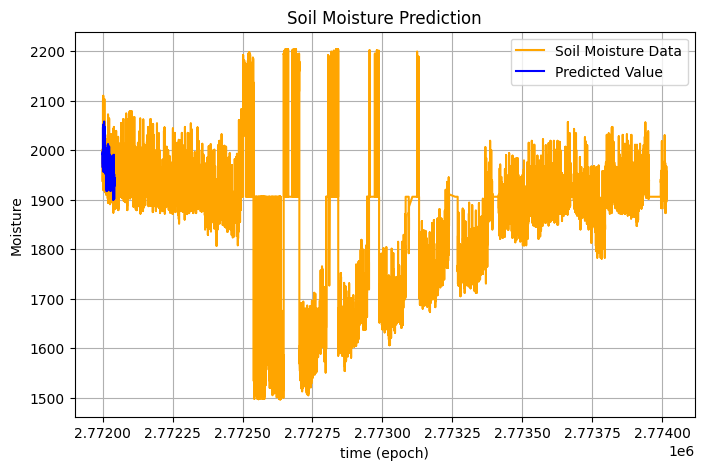

In [279]:
# === Step 1: Initialize Data ===
ts = pd.DataFrame(sensor_wo_mp_df1.epoch_time / 60).astype(int)
ys = pd.DataFrame(sensor_wo_mp_df1.moisture)

ph = 5  # 5 minutes prediction horizon
ph_index = math.ceil(ph / freq_ingestion)
n_s = 5000  # Number of samples limit

# === Step 2: Define Model Execution Function ===
def execute_model2(mu, ts, ys):
    tp_pred = np.zeros(n_s - 1)
    yp_pred = np.zeros(n_s - 1)

    for i in range(2, n_s + 1):
        ts_tmp = ts[:i]
        ys_tmp = ys[:i]
        ns = len(ys_tmp)

        weights = np.power(mu, np.arange(ns)[::-1])

        lm = LinearRegression()
        lm.fit(ts_tmp.values, ys_tmp.values, sample_weight=weights)

        tp_pred[i-2] = ts_tmp.values[-1]
        yp_pred[i-2] = lm.predict(ts_tmp.values[-1].reshape(1, -1))

    return tp_pred, yp_pred

# === Step 3: Grid Search for Hyperparameter Tuning ===
param_grid = {'mu': [0.01, 0.1, 0.5, 1]}

results = []
for mu in param_grid['mu']:
    tp_pred, yp_pred = execute_model2(mu, ts, ys)
    mse = np.mean((ys.values[:len(yp_pred)] - yp_pred) ** 2)
    results.append((mu, mse))
    print(f"mu={mu}, MSE={mse}")

# Select Best mu
best_mu = min(results, key=lambda x: x[1])[0]
print(f"Best mu: {best_mu}")

# === Step 4: Cross-Validation ===
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []
for train_index, test_index in tscv.split(ts):
    ts_train, ts_test = ts.iloc[train_index], ts.iloc[test_index]
    ys_train, ys_test = ys.iloc[train_index], ys.iloc[test_index]

    tp_pred, yp_pred = execute_model2(best_mu, ts_train, ys_train)

    mse = np.mean((ys_test.values[:len(yp_pred)] - yp_pred) ** 2)
    mse_scores.append(mse)
    print(f"Fold MSE: {mse}")

avg_mse = np.mean(mse_scores)
print(f"Average Cross-Validation MSE: {avg_mse}")

# === Step 5: Final Model Plot ===
tp_pred, yp_pred = execute_model2(best_mu, ts, ys)
plt.figure(figsize=(8, 5))
plt.plot(ts.values[:len(ys)], ys.values, label='Soil Moisture Data', color='orange')
plt.plot(tp_pred, yp_pred, label='Predicted Value', color='blue')
plt.xlabel('time (epoch)')
plt.ylabel('Moisture')
plt.title('Soil Moisture Prediction')
plt.legend()
plt.grid(True)
plt.show()

### Model Performance Evaluation and Next Steps

1. Performance Improvement Analysis:  
  - **MSE Comparison for Different `mu` Values:**  
    - `mu = 0.01`: MSE = 913.82  
    - `mu = 0.1`: MSE = 904.88  
    - `mu = 0.5`: MSE = **879.58 (Best)**  
    - `mu = 1`: MSE = 1038.24  

**Observation:**  
  - The best-performing learning rate (`mu`) is **0.5**, with the lowest MSE of **879.58** on the training set.  
  - Increasing `mu` beyond 0.5 (`mu=1`) causes performance to degrade (MSE: 1038.24).  
  - This suggests that a moderate `mu` (0.5) balances bias and variance effectively.

---

2. Cross-Validation Results:
  - **5-Fold Cross-Validation MSEs:**  
    - Fold 1: 875.18  
    - Fold 2: 2656.62  
    - Fold 3: 75137.75 (Outlier)  
    - Fold 4: 6341.18  
    - Fold 5: 2007.55  

  - **Average Cross-Validation MSE:** **17403.66**  

**Observation:**  
  - The cross-validation results show high variability, with Fold 3 having a **significantly larger MSE (75137.75)** than the others.  
  - This indicates **possible overfitting to certain time segments** or **anomalies in the data.**

---  

In [280]:
def append_visualisation_dataset(sensor_data_with_tr_prediction, tp_pred, yp_pred, column_name):
  tr_prediction = pd.DataFrame()
  tr_prediction['epoch_time'] = tp_pred
  tr_prediction[column_name] = yp_pred

  tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
  tr_prediction[column_name] = tr_prediction[column_name].astype(int)

  sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

  print(sensor_data_with_tr_prediction.head())

#append_visualisation_dataset(sensor_data_with_tr_prediction, tp_pred, yp_pred,'lr_tr_hpt_mu001_pred_moisture')

In [282]:
sensor_data_with_tr_prediction.to_csv("sensor_result_data.csv")

##**Build LSTM model and evaluate performance**

In [ ]:
"""
## 1. Set Random Seed for Reproducibility
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import gc
from keras import backend as K

np.random.seed(1123456)
tf.random.set_seed(1123456)

## 2. Data Preprocessing
sensor_wo_mp_df = sensor_wo_mp_df.reset_index(drop=True)
#df_lstm = sensor_wo_mp_df.sample(frac=0.1, random_state=1123456)  # Reduced fraction for memory efficiency
df_lstm = sensor_wo_mp_df[:5000]  # Reduced fraction for memory efficiency
train_df_lstm, val_df_lstm = train_test_split(df_lstm, test_size=0.2, random_state=1123456)

## 3. Data Restructuring Function
def restructure_data(data, seq_length, ph, feat_cols):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - ph):
        seq = data[feat_cols].iloc[i:i+seq_length].values
        label = data['moisture'].iloc[i+seq_length+ph-1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences, dtype=np.float32), np.array(labels, dtype=np.float32)

feat_cols = ['temperature', 'humidity', 'light']
seq_length, ph = 30, 5
seq_arrays, seq_labs = restructure_data(train_df_lstm, seq_length, ph, feat_cols)
val_arrays, val_labs = restructure_data(val_df_lstm, seq_length, ph, feat_cols)

train_dataset = tf.data.Dataset.from_tensor_slices((seq_arrays, seq_labs)).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_arrays, val_labs)).batch(64).prefetch(tf.data.AUTOTUNE)

## 4. Optimized LSTM Model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(seq_length, len(feat_cols))),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(1, activation='relu')
])

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

## 5. Predict on Entire Dataset in Batches
full_arrays, _ = restructure_data(sensor_wo_mp_df, seq_length, ph, feat_cols)
batch_size = 1024
full_predictions = []
for i in range(0, len(full_arrays), batch_size):
    batch_predictions = model.predict(full_arrays[i:i+batch_size], verbose=0)
    full_predictions.extend(batch_predictions.flatten())

sensor_wo_mp_df['predicted_moisture'] = np.nan
pred_start = seq_length + ph - 1
sensor_wo_mp_df.loc[pred_start:pred_start+len(full_predictions)-1, 'predicted_moisture'] = full_predictions

## 6. Save for Tableau
downsampled_df = sensor_wo_mp_df.iloc[::10].reset_index(drop=True)
downsampled_df.to_csv('lstm_predictions_for_tableau.csv', index=False)
print("Predictions saved to lstm_predictions_for_tableau.csv")

## 7. Clear Memory
K.clear_session()
gc.collect()
"""


# LSTM for Real-Time Soil Moisture Prediction

In [283]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(sensor_wo_mp_df1) * 0.01)
print(f'Subset size: {subset_size}')

#take random data subset
subset = sensor_wo_mp_df.sample(n=subset_size, random_state=42)
print(f'Subset shape: {subset.shape}')
print(subset.head())

# Sort the subset by time to maintain the temporal order
subset = subset.sort_index()
print(subset.head())


#split data subset 80/20 for train/validation
train_size = int(len(subset) * 0.8)
train_df = subset[:train_size].copy()
val_df = subset[train_size:].copy()

#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

# display the shapes of the resulting datasets
print(f'Training set shape: {train_df.shape}')
print(f'Validation set shape: {val_df.shape}')

seq_arrays = []
seq_labs = []

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['temperature', 'humidity', 'light']

#create list of sequence length moisture readings
for start in range(len(train_df) - seq_length - ph):
    seq_arrays.append(train_df.loc[start:start+seq_length-1, feat_cols].values)
    seq_labs.append(train_df.loc[start+seq_length+ph-1, 'moisture'])

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

# Print actual shapes
print(f'Actual seq_arrays shape: {seq_arrays.shape}')
print(f'Expected seq_arrays shape: {(len(train_df)-seq_length-ph, seq_length, len(feat_cols))}')
print(f'Actual seq_labs shape: {seq_labs.shape}')
print(f'Expected seq_labs shape: {(len(train_df)-seq_length-ph,)}')

assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

seq_arrays.shape

Subset size: 2254
Subset shape: (2254, 11)
        temperature  humidity  moisture  light        date      time  \
87733           8.6      75.5      1593    0.0  2022-09-20  05:08:51   
115550         12.0      67.8      1695    0.0  2022-09-21  21:10:50   
183125         15.8      80.1      1907    0.0  2022-09-25  22:37:24   
203080         14.5      80.6      1887    0.0  2022-09-27  03:23:43   
14053          19.9      81.5      1933    0.0  2022-09-15  19:53:32   

           msmt_taken_time  hour  day  month            diff  
87733  2022-09-20 05:08:51     5   20      9 0 days 00:00:05  
115550 2022-09-21 21:10:50    21   21      9 0 days 00:00:05  
183125 2022-09-25 22:37:24    22   25      9 0 days 00:00:05  
203080 2022-09-27 03:23:43     3   27      9 0 days 00:00:05  
14053  2022-09-15 19:53:32    19   15      9 0 days 00:00:05  
     temperature  humidity  moisture  light        date      time  \
238         24.5      59.0      1995    0.0  2022-09-15  00:20:17   
302     

(1768, 30, 3)

In [284]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define path to save the model
model_path = 'LSTM_model1.keras'

# Prepare the data for LSTM
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X.iloc[i:(i + time_step)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_step])
    return np.array(Xs), np.array(ys)

# Define the sequence length (time steps)
seq_length = 10

# Create the dataset for LSTM
X_train, y_train = create_dataset(train_df[['temperature', 'humidity', 'light']], train_df['moisture'], seq_length)
X_val, y_val = create_dataset(val_df[['temperature', 'humidity', 'light']], val_df['moisture'], seq_length)

# Define the number of features and outputs
nb_features = X_train.shape[2]  # Should be 3, matching ['temperature', 'humidity', 'light']
nb_out = 1  # Predicting a single value (moisture)

# Build the LSTM network
model = Sequential()

# Add Input layer to avoid the warning
model.add(Input(shape=(seq_length, nb_features)))

# Add first LSTM layer
model.add(LSTM(
    units=5,
    return_sequences=True))
model.add(Dropout(0.2))

# Add second LSTM layer
model.add(LSTM(
    units=3,
    return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense layer with a linear activation function
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print the model summary
print(model.summary())

# Fit the network
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=500,
    validation_split=0.05,
    verbose=2,
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
        ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    ]
)

# List all data in history
print(history.history.keys())

# Make predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

# Combine predictions with the original dataset
def combine_predictions(original_df, predictions, time_step):
    # Create a DataFrame for predictions
    pred_df = pd.DataFrame(predictions, columns=['predicted_moisture'])

    # Align predictions with the original dataset
    pred_df.index = original_df.index[time_step:]

    # Combine predictions with the original dataset
    combined_df = original_df.iloc[time_step:].copy()
    combined_df['predicted_moisture'] = pred_df['predicted_moisture']

    return combined_df

# Combine predictions for training and validation sets
train_combined_df = combine_predictions(train_df, train_predict, seq_length)
val_combined_df = combine_predictions(val_df, val_predict, seq_length)

# Save the combined data to CSV files
train_combined_df.to_csv('train_predictions.csv', index=False)
val_combined_df.to_csv('val_predictions.csv', index=False)

# Print the first few rows of the combined data
print("Training Data with Predictions:")
print(train_combined_df.head())

print("Validation Data with Predictions:")
print(val_combined_df.head())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 5)               │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
4/4 - 6s - 1s/step - loss: 3584048.0000 - mse: 3584048.0000 - val_loss: 3634689.5000 - val_mse: 3634689.5000
Epoch 2/5
4/4 - 0s - 43ms/step - loss: 3583521.2500 - mse: 3583521.2500 - val_loss: 3634250.0000 - val_mse: 3634250.0000
Epoch 3/5
4/4 - 0s - 42ms/step - loss: 3583033.5000 - mse: 3583033.5000 - val_loss: 3633868.7500 - val_mse: 3633868.7500
Epoch 4/5
4/4 - 0s - 75ms/step - loss: 3582496.7500 - mse: 3582496.7500 - val_loss: 3633484.5000 - val_mse: 3633484.5000
Epoch 5/5
4/4 - 0s - 75ms/step - loss: 3581914.7500 - mse: 3581914.7500 - val_loss: 3633087.2500 - val_mse: 3633087.2500
dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training Data with Predictions:
    index  temperature  humidity  moisture  light        date      time  \
10   1156         24.3      61.4      1991    0.0  2022-09-15  01:38:00   
11   1197         24.3      61.6      1991    0.0  2022-09-15  01:41:28   
12   1

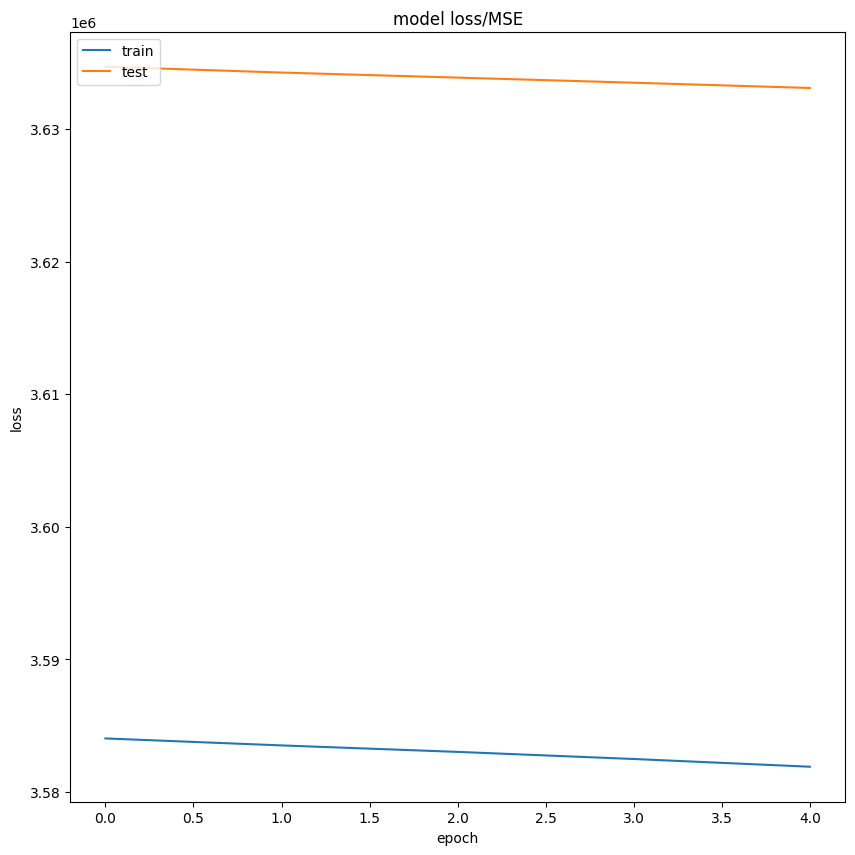

In [285]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the figure
fig_acc.savefig("LSTM_loss1.png")

In [286]:
# initialize lists for validation sequences and labels
val_arrays = []
val_labs = []

#create list of moisture readings starting with a minimum of two readings
for start in range(2, len(val_df) - seq_length - ph):
    # Updated to extract all features specified in feat_cols
    seq = val_df.loc[start:start+seq_length-1, feat_cols].values
    val_arrays.append(seq)
    val_labs.append(val_df.loc[start + seq_length + ph - 1, 'moisture'])  # Updated target index to align with training data preparation


# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)  # Convert to NumPy array before padding

# Padding is generally not needed if all sequences have the same length
# If sequences have varying lengths, consider padding them properly using pad_sequences
# val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='pre', dtype='float32')

# Reshape val_arrays to match the model's input shape if necessary
# This reshape should now work as val_arrays has the expected structure
# val_arrays = val_arrays.reshape((val_arrays.shape[0], val_arrays.shape[1], nb_features))

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

14/14 - 1s - 41ms/step - loss: 3953392.0000 - mse: 3953392.0000

MSE: 3953392.0
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


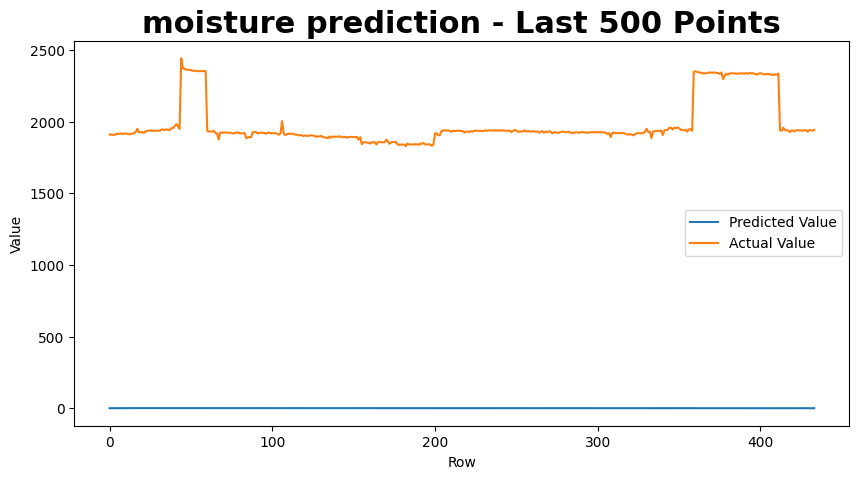

In [287]:
# Evaluate the model on the validation data
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

# Generate predictions
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Save predictions to CSV file
test_set = pd.DataFrame(y_pred_test, columns=['predicted_moisture'])
test_set.to_csv('submit_test.csv', index=None)

# Plot the predicted data vs. the actual data
# We will limit our plot to the first 500 predictions for better visualization
import matplotlib.pyplot as plt

fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('moisture prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()

# Save the figure
fig_verify.savefig("model_regression_verify.png")

#**Build LSTM model for predicting temperature**

In [288]:
sensor_wo_mp_df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225418 entries, 0 to 233979
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   temperature      225418 non-null  float64        
 1   humidity         225418 non-null  float64        
 2   moisture         225418 non-null  int64          
 3   light            225418 non-null  float64        
 4   date             225418 non-null  object         
 5   time             225418 non-null  object         
 6   msmt_taken_time  225418 non-null  datetime64[ns] 
 7   hour             225418 non-null  int32          
 8   day              225418 non-null  int32          
 9   month            225418 non-null  int32          
 10  diff             225417 non-null  timedelta64[ns]
 11  diff_sec         225418 non-null  int64          
 12  epoch_time       225418 non-null  int64          
dtypes: datetime64[ns](1), float64(3), int32(3), int64(3), object(2),

In [289]:
temp_df1=sensor_wo_mp_df1[["msmt_taken_time", "temperature"]]

In [290]:
temp_df1.head()

msmt_taken_time  temperature
0 2022-09-15 00:00:04         24.7
1 2022-09-15 00:00:09         24.7
2 2022-09-15 00:00:14         24.7
3 2022-09-15 00:00:19         24.6
4 2022-09-15 00:00:25         24.6

In [291]:
temp_df1["temperature"].max()

25.4

<ipython-input-292-24ed4dc77410>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


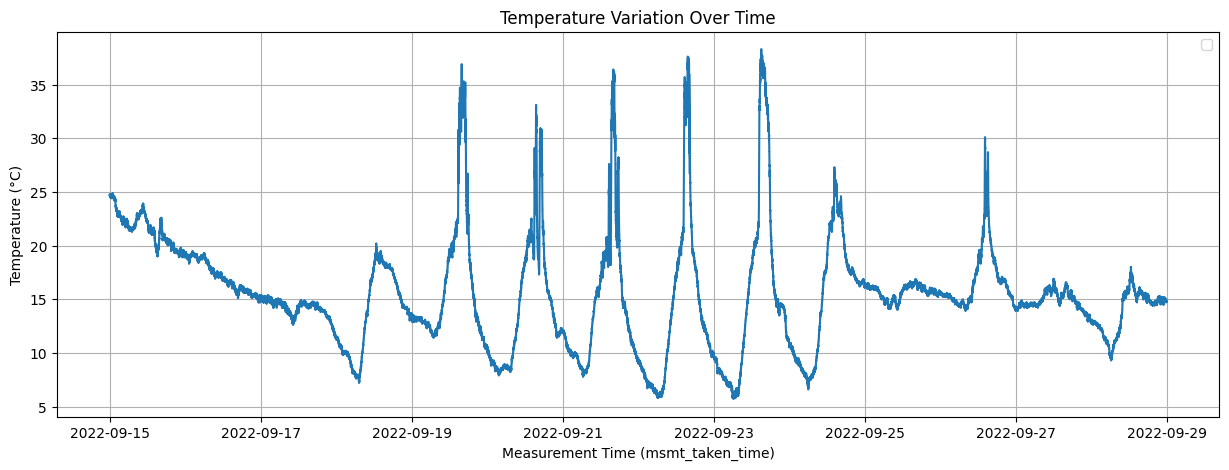

In [292]:
plt.figure(figsize = (15, 5))
plt.plot(sensor_wo_mp_df['msmt_taken_time'], sensor_wo_mp_df['temperature'])
plt.xlabel('Measurement Time (msmt_taken_time)')
plt.ylabel('Temperature (°C)')
plt.title("Temperature Variation Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [293]:
from sklearn.preprocessing import MinMaxScaler

# Apply the MinMax scaler to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
temp_ds = scaler.fit_transform(sensor_wo_mp_df['temperature'].values.reshape(-1, 1))

# Print first five values for sanity testing
print(temp_ds[0:5])
temp_ds.shape

[[0.58282209]
 [0.58282209]
 [0.58282209]
 [0.5797546 ]
 [0.5797546 ]]


(233980, 1)

In [306]:
int(temp_ds.shape[0]*.01) , int(temp_ds.shape[0]*.015)

(2339, 3509)

In [316]:
## 2. Data Preprocessing
#Create training and validation dataset.
temp_ds = pd.DataFrame(temp_ds, columns=['temperature'])

train_df_temp = temp_ds[:int(temp_ds.shape[0]*.01)]
val_df_temp = temp_ds[int(temp_ds.shape[0]*.01):int(temp_ds.shape[0]*.015)]

input_train_ds = pd.DataFrame()
input_temp_ds = pd.DataFrame()
a = int(temp_ds.shape[0]*.01)
b = int(temp_ds.shape[0]*.015)
input_train_ds['train_temp'] = sensor_wo_mp_df1['temperature'][:int(temp_ds.shape[0]*.01)]
input_temp_ds['test_temp'] = sensor_wo_mp_df1['temperature'][a:b]


In [319]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset['temperature'].iloc[i:(i + window_size)].values # Use iloc for integer-based indexing
        data_X.append(a)
        data_Y.append(dataset['temperature'].iloc[i + window_size]) # Use iloc for integer-based indexing
    return(np.array(data_X), np.array(data_Y))


In [320]:
# Create test and training sets for one-step-ahead regression.
print(train_df_temp[:5])

print(val_df_temp[:5])

window_size = 1
train_X, train_Y = create_dataset(train_df_temp, window_size)
test_X, test_Y = create_dataset(val_df_temp, window_size)
print("Original training data shape:")
print(train_X.shape)
print(train_X[:5])

print("Train Y")
print(train_Y.shape)

print("Test X")
print(test_X.shape)

print("Test Y")
print(test_Y.shape)

   temperature
0     0.582822
1     0.582822
2     0.582822
3     0.579755
4     0.579755
      temperature
2339      0.52454
2340      0.52454
2341      0.52454
2342      0.52454
2343      0.52454
Original training data shape:
(2337, 1)
[[0.58282209]
 [0.58282209]
 [0.58282209]
 [0.5797546 ]
 [0.5797546 ]]
Train Y
(2337,)
Test X
(1168, 1)
Test Y
(1168,)


In [321]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

New training data shape:
(2337, 1, 1)


In [ ]:
model = Sequential()
model.add(LSTM(input_shape = (window_size, 1),
            units = window_size,
            return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss = "mse",
          optimizer = "adam")
model.summary()

In [ ]:
model.fit(train_X, train_Y, epochs = 5,
            batch_size = 1,
            verbose = 1)

In [322]:
# Define the model.
def fit_model_new(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(input_shape = (window_size, 1),
               units = window_size,
               return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss = "mse",
              optimizer = "adam")
    model.summary()

    # Fit the first model.
    model.fit(train_X, train_Y, epochs = 5,
              batch_size = 1,
              verbose = 0)
    return(model)

In [323]:
model3=fit_model_new(train_X, train_Y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 1)                │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,461 (1.01 MB)

 Trainable params: 264,461 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [324]:
from sklearn.metrics import mean_squared_error

def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred_scaled =model.predict(X)
    pred = scaler.inverse_transform(pred_scaled)
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, pred_scaled)

rmse_train, train_predict, train_predict_scaled = predict_and_score(model3, train_X, train_Y)
rmse_test, test_predict, test_predict_scaled = predict_and_score(model3, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

test_predict.size

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training data score: 0.39 RMSE
Test data score: 0.86 RMSE


1168

In [326]:
X_single = test_X[0:1,:,:]

# create empty array
from numpy import empty
test_predict_at_a_time = empty([test_X.size,1])

print("initial X: ", X_single)
for i in range((test_X.size)):
    Y_single = test_Y[i:i+1]
    rmse_test, predict, predict_scaled = predict_and_score(model3, X_single, Y_single)
    test_predict_at_a_time[i]= predict
    X_single = predict_scaled.copy()
    X_single=np.reshape(X_single[0], (1, 1, 1))
    #print("given X: ", X_single)

test_predict_at_a_time[-3:]

initial X:  [[[0.52453988]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━

array([[23.96472168],
       [23.96472168],
       [23.96472168]])

In [327]:
test_predict_at_a_time = scaler.inverse_transform(test_predict_at_a_time)
test_X_inverse = scaler.inverse_transform(test_X.reshape(-1, 1))
print(test_predict_at_a_time)
print(test_X_inverse)

[[769.22396278]
 [778.64677849]
 [783.05487442]
 ...
 [786.94992676]
 [786.94992676]
 [786.94992676]]
[[22.8]
 [22.8]
 [22.8]
 ...
 [22.3]
 [22.3]
 [22.3]]


In [328]:


# Start with training predictions.
train_predict_plot = np.empty_like(train_df_temp)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict


# Add test predictions.
test_predict_plot = np.empty_like(val_df_temp)
test_predict_plot[:, :] = np.nan

# Adjust the slice indices to ensure a valid range
# The original start_index was causing the issue.
# It was greater than the length of the array it was trying to index into.
start_index = window_size
end_index = min(start_index + len(test_predict), len(val_df_temp) - 1) #ensure end_index doesn't exceed the array bounds

#Assign values only if the slice is not empty
if start_index < end_index:
    test_predict_plot[start_index:end_index, :] = test_predict[:end_index - start_index]

# Add test predictions.
test_predict_at_a_time_plot = np.empty_like(val_df_temp)
test_predict_at_a_time_plot[:, :] = np.nan
# The original start index was also an issue here. Adjusted for consistency.
test_predict_at_a_time_plot[window_size:len(test_predict_at_a_time) + window_size, :] = test_predict_at_a_time

In [329]:
tr = pd.Series(train_Y)
te = pd.Series(test_Y)

plot_data = pd.concat([tr, te])
plot_data = plot_data.reset_index(drop=True)

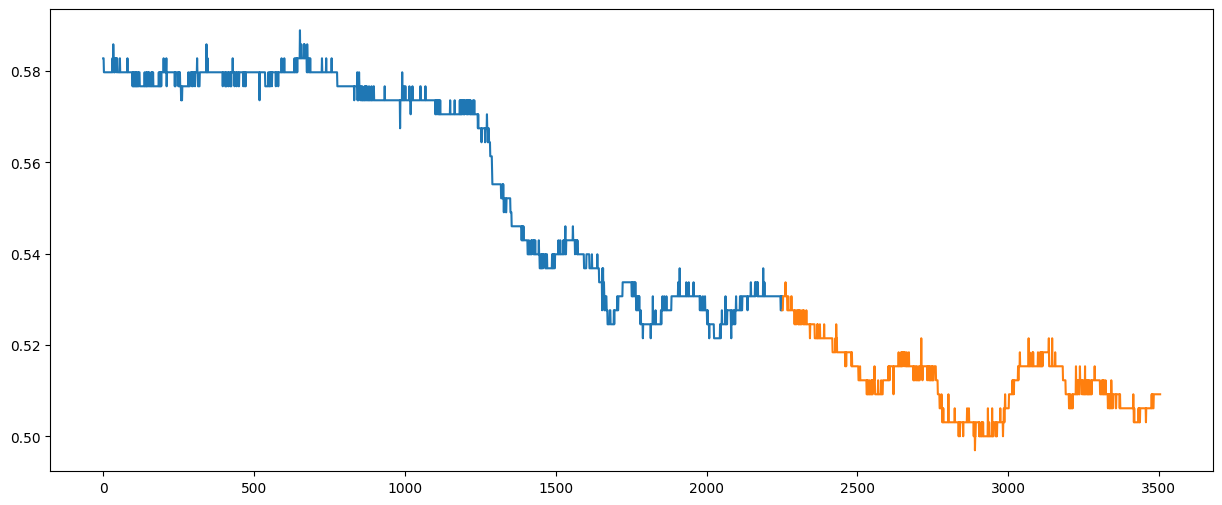

In [331]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_Y and test_Y are pandas Series with a DatetimeIndex
plot_data[:2252].plot(label='Train', figsize=(15, 6))
plot_data[2252:].plot(label='Test', figsize=(15, 6))

plt.show()

In [332]:
scaler = MinMaxScaler(feature_range = (0, 1))
temp_ds = scaler.fit_transform(test_predict_at_a_time.reshape(-1, 1))
pred = temp_ds.reshape(1,-1)[0]

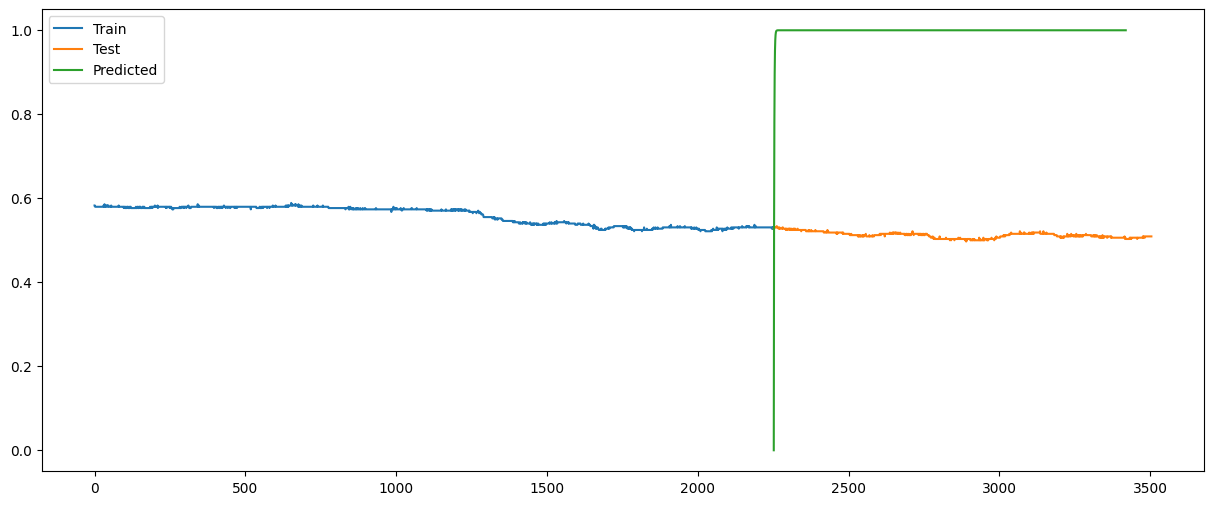

In [333]:

plot_data[:2252].plot(label='Train', figsize=(15, 6))
plot_data[2252:].plot(label='Test', figsize=(15, 6))

predicted = pd.Series(pred)
predicted.index = list(range(2252, 2252+len(pred)))
predicted.plot(label='Predicted', figsize=(15, 6))
plt.legend()
plt.show()

#**Temperature Prediction using Linear Regression**


In [334]:
ts = pd.DataFrame(sensor_wo_mp_df1.epoch_time)
ys = pd.DataFrame(sensor_wo_mp_df1.temperature)

ph = 60*60 #Converted Minutes to seconds since the frequency
ph_index = math.ceil(ph/freq_ingestion)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [335]:
execute_model(mu,ts,ys)

tp_pred [1.66320000e+08 1.66320001e+08 1.66320001e+08 ... 1.66322545e+08
 1.66322545e+08 1.66322546e+08]
yp_pred [24.6        24.7        24.64736842 ... 21.76062828 21.7678062
 21.77264272]


Mu :  0.9
Mu :  0.9
MSE is 0.0012644643203799334


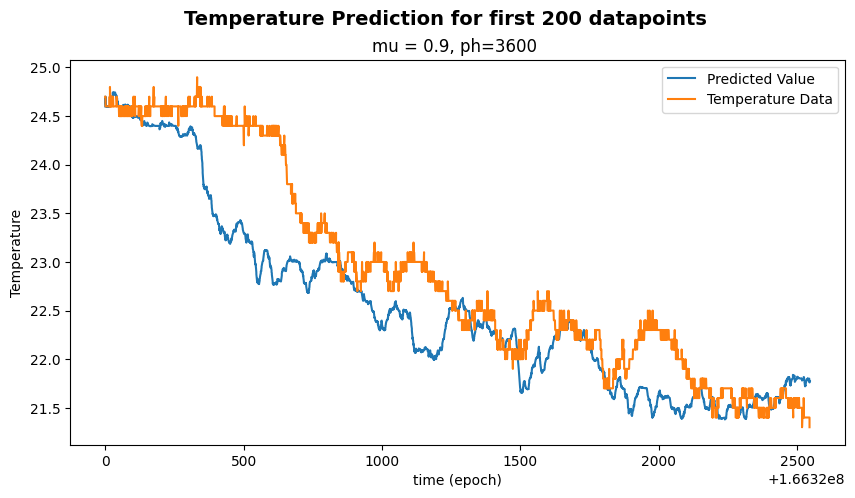

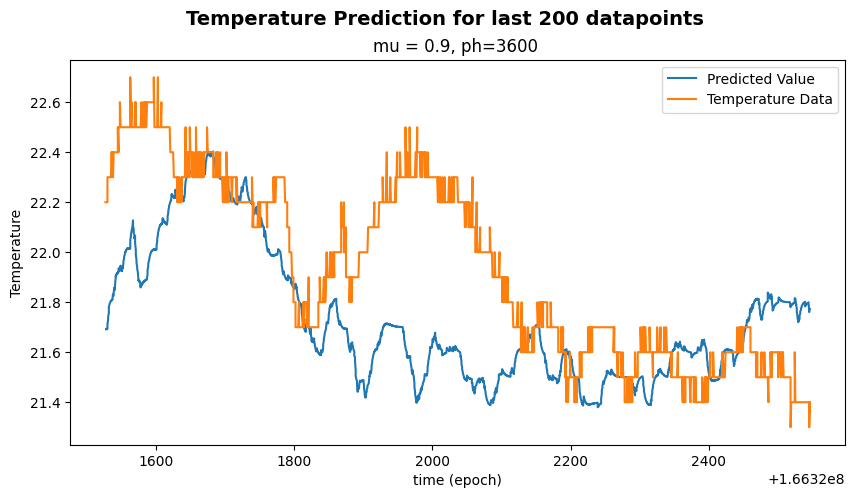

In [337]:
plot_result_mse(ts, ys, tp_pred, yp_pred, 'Temperature')

In [339]:
#sensor_data_with_tr_prediction = sensor_wo_mp_df1[:n_s-1]
tr_prediction = pd.DataFrame()
tr_prediction['epoch_time'] = tp_pred
tr_prediction['lr_tr_mu09_pred_temperature'] = yp_pred

tr_prediction['epoch_time'] = tr_prediction['epoch_time'].astype(int)
#tr_prediction['lr_tr_mu09_pred_temperature'] = tr_prediction['lr_tr_mu09_pred_temperature'].astype(float)

sensor_data_with_tr_prediction = pd.merge(sensor_data_with_tr_prediction, tr_prediction, on="epoch_time", how='left')

sensor_data_with_tr_prediction.head()

temperature  humidity  moisture  light        date      time  \
0         24.7      57.9      1995    0.0  2022-09-15  00:00:04   
1         24.7      58.0      1991    0.0  2022-09-15  00:00:09   
2         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
3         24.7      58.2      1994    0.0  2022-09-15  00:00:14   
4         24.7      58.2      1994    0.0  2022-09-15  00:00:14   

      msmt_taken_time  hour  day  month            diff  diff_sec  epoch_time  \
0 2022-09-15 00:00:04     0   15      9             NaT         0   166320000   
1 2022-09-15 00:00:09     0   15      9 0 days 00:00:05         5   166320000   
2 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
3 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   
4 2022-09-15 00:00:14     0   15      9 0 days 00:00:05         5   166320001   

   lr_tr_mu09_pred_moisture  lr_tr_mu1_pred_moisture  \
0                      1997                     1997   
1                      1997                     1997   
2                      1985                     1985   
3                      1985                     1985   
4                      1985                     1985   

   lr_tr_mu001_pred_moisture  lr_tr_mv_mu1_pred_moisture  \
0                       1999                        1991   
1                       1999                        1991   
2                       1985                        1993   
3                       1985                        1993   
4                       1985                        1993   

   lr_tr_mu09_pred_temperature  
0                    24.600000  
1                    24.600000  
2                    24.700000  
3                    24.647368  
4                    24.700000

In [340]:
sensor_data_with_tr_prediction['lr_tr_mu09_pred_temperature'].isna().sum()

0

In [343]:
sensor_data_with_tr_prediction.to_csv("./sensor_result_data.csv")
df = pd.read_csv("./sensor_result_data.csv")
df.describe()


Unnamed: 0    temperature       humidity       moisture  \
count  157023.000000  157023.000000  157023.000000  157023.000000   
mean    78511.000000      22.896771      70.843345    1960.114722   
std     45328.779997       1.077245       6.715218      23.762283   
min         0.000000      21.300000      57.900000    1874.000000   
25%     39255.500000      22.100000      63.000000    1941.000000   
50%     78511.000000      22.600000      74.100000    1953.000000   
75%    117766.500000      24.200000      75.900000    1985.000000   
max    157022.000000      24.900000      78.800000    2110.000000   

               light           hour       day     month       diff_sec  \
count  157023.000000  157023.000000  157023.0  157023.0  157023.000000   
mean        0.154566       3.039160      15.0       9.0       5.081479   
std         0.564170       2.029401       0.0       0.0       0.313206   
min         0.000000       0.000000      15.0       9.0       0.000000   
25%         0.000000       1.000000      15.0       9.0       5.000000   
50%         0.000000       3.000000      15.0       9.0       5.000000   
75%         0.000000       5.000000      15.0       9.0       5.000000   
max         2.961658       7.000000      15.0       9.0      10.000000   

         epoch_time  lr_tr_mu09_pred_moisture  lr_tr_mu1_pred_moisture  \
count  1.570230e+05             157023.000000            157023.000000   
mean   1.663213e+08               1952.424403              1947.916617   
std    7.345354e+02                 20.371657                23.765959   
min    1.663200e+08               1918.000000              1921.000000   
25%    1.663206e+08               1935.000000              1929.000000   
50%    1.663213e+08               1947.000000              1940.000000   
75%    1.663219e+08               1965.000000              1963.000000   
max    1.663225e+08               2014.000000              1997.000000   

       lr_tr_mu001_pred_moisture  lr_tr_mv_mu1_pred_moisture  \
count              157023.000000               157023.000000   
mean                 1952.458697                 1960.810263   
std                    21.550290                   22.111794   
min                  1874.000000                 1919.000000   
25%                  1935.000000                 1942.000000   
50%                  1947.000000                 1953.000000   
75%                  1967.000000                 1988.000000   
max                  2102.000000                 1998.000000   

       lr_tr_mu09_pred_temperature  
count                157023.000000  
mean                     22.541050  
std                       0.945890  
min                      21.379925  
25%                      21.713048  
50%                      22.314869  
75%                      23.003017  
max                      24.745839